<a href="https://colab.research.google.com/github/Leeyeji13/Section2_project/blob/main/AI_13_%EC%9D%B4%EC%98%88%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 항공 이용 고객 만족도 분류

* 마지막으로 비행기에 탑승했을 때 얼마나 만족하셨나요? 많은 사람들이 지난 탑승 경험에 긍정적이거나 부정적인 영향을 준 몇가지 요인을 떠올리고, 그 결과로 만족도가 어느 정도였는지 판단할 수 있을 것이다.

* 항공사의 경우, 항공편에 탑승한 고객의 만족도가 주된 지표로 작용한다. 물론 탑승객이 만족했다는 사실을 확인하는 것도 좋지만, 만족한 이유를 아는 것이 더 중요하다. 이러한 통찰력은 항공사가 고객의 입장에서 자사의 강점과 개선할 점을 파악하는 데 매우 유용하다.

* 따라서 다양한 사유를 통해 고객의 만족, 불만족 문제(분류)로 예측하고자 한다.

* 이를 통하여 소비자의 만족도도 높일 뿐 아니라, 항공사의 편익에도 기여할 수 있을 것으로 기대한다.

해결하고자 하는 문제 : 항공사 만족도 예측

데이터 : 케글 "Airline Passenger Satisfaction"

선정 이유 : 여행과 관련된 도메인

## 데이터 업로드

In [95]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [96]:
!pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [98]:
from google.colab import files
import pandas as pd
import io
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression
import eli5
from eli5.sklearn import PermutationImportance

warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rc('font', family='NanumBarunGothic')

In [99]:
uploaded1 = files.upload()
uploaded2 = files.upload()

Saving train.csv to train (1).csv


Saving test.csv to test (1).csv


In [100]:
train = pd.read_csv(io.StringIO(uploaded1['train.csv'].decode('utf8')))
test = pd.read_csv(io.StringIO(uploaded2['test.csv'].decode('utf8')))

In [101]:
train.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [102]:
test.columns

Index(['Unnamed: 0', 'id', 'Gender', 'Customer Type', 'Age', 'Type of Travel',
       'Class', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction'],
      dtype='object')

In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

In [104]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25976 entries, 0 to 25975
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         25976 non-null  int64  
 1   id                                 25976 non-null  int64  
 2   Gender                             25976 non-null  object 
 3   Customer Type                      25976 non-null  object 
 4   Age                                25976 non-null  int64  
 5   Type of Travel                     25976 non-null  object 
 6   Class                              25976 non-null  object 
 7   Flight Distance                    25976 non-null  int64  
 8   Inflight wifi service              25976 non-null  int64  
 9   Departure/Arrival time convenient  25976 non-null  int64  
 10  Ease of Online booking             25976 non-null  int64  
 11  Gate location                      25976 non-null  int

***-> Gender, Customer Type, Type of Travel, Class : 범주형 데이터***

***-> Age, Flight Distance, Departure Delay in Minutes, Arrival Delay in Minutes 를 제외한 features : 0 ~ 5 사이의 정도를 나타내는 정수형***

## EDA

### 가설

가설 1. 개인적인 여행일수록 만족도가 높을 것이다.

가설 2. 고객의 만족도에 클래스를 고려해야할까?

### 칼럼 정리

In [105]:
#쓸데없는 컬럼 제거
train.drop(['Unnamed: 0', 'id'], axis = 1, inplace = True)
test.drop(['Unnamed: 0', 'id'], axis = 1, inplace = True)

In [106]:
#칼럼명 정리
train.columns = [c.replace(' ','_') for c in train.columns]
test.columns = [c.replace(' ','_') for c in test.columns]

### Baseline

In [107]:
train['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)

In [108]:
train['satisfaction'].value_counts(normalize = True)

0    0.566667
1    0.433333
Name: satisfaction, dtype: float64

Text(0.5, 1.0, "Passengers' Satisfaction Rate")

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


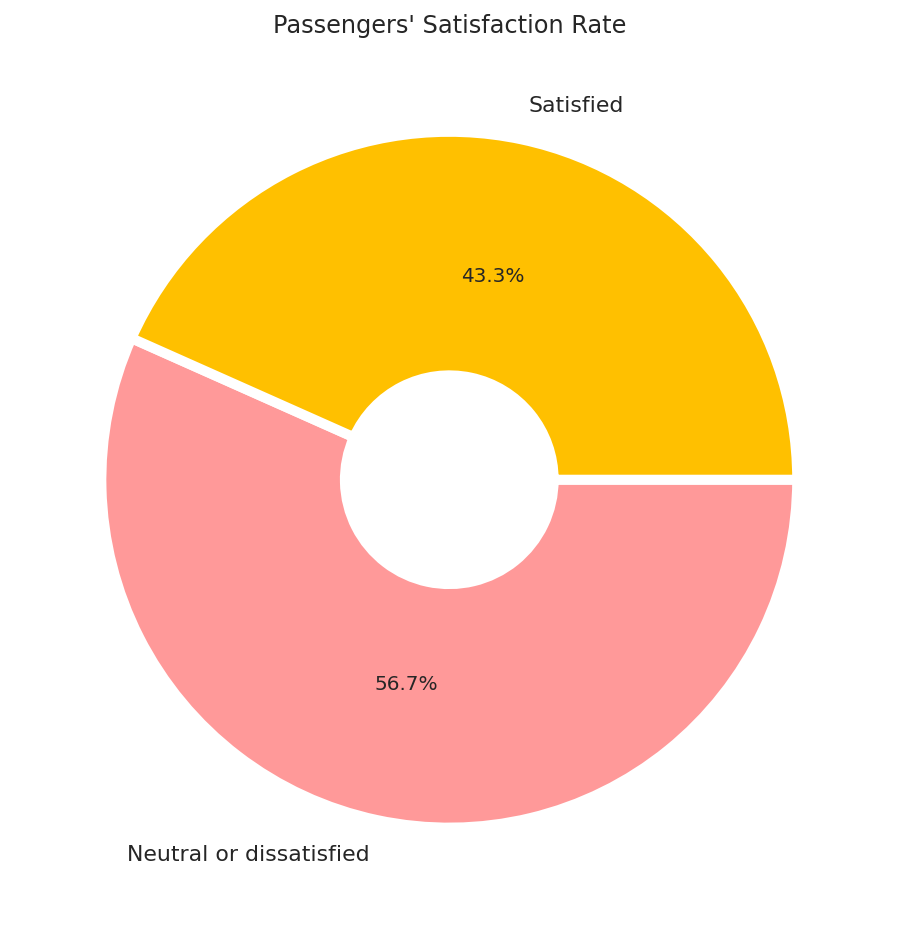

In [109]:
wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}
plt.figure(figsize=(8, 8))
train['satisfaction'].value_counts().plot(kind = "pie", autopct = '%1.1f%%', colors = ['#ff9999', '#ffc000'], counterclock = False, wedgeprops = wedgeprops, labels = ["Neutral or dissatisfied", "Satisfied"])
plt.ylabel("")
plt.title("Passengers' Satisfaction Rate")

***=> Baseline : 0.57***

### 결측치

In [110]:
train.isna().sum()

Gender                                 0
Customer_Type                          0
Age                                    0
Type_of_Travel                         0
Class                                  0
Flight_Distance                        0
Inflight_wifi_service                  0
Departure/Arrival_time_convenient      0
Ease_of_Online_booking                 0
Gate_location                          0
Food_and_drink                         0
Online_boarding                        0
Seat_comfort                           0
Inflight_entertainment                 0
On-board_service                       0
Leg_room_service                       0
Baggage_handling                       0
Checkin_service                        0
Inflight_service                       0
Cleanliness                            0
Departure_Delay_in_Minutes             0
Arrival_Delay_in_Minutes             310
satisfaction                           0
dtype: int64

In [111]:
test.isna().sum()

Gender                                0
Customer_Type                         0
Age                                   0
Type_of_Travel                        0
Class                                 0
Flight_Distance                       0
Inflight_wifi_service                 0
Departure/Arrival_time_convenient     0
Ease_of_Online_booking                0
Gate_location                         0
Food_and_drink                        0
Online_boarding                       0
Seat_comfort                          0
Inflight_entertainment                0
On-board_service                      0
Leg_room_service                      0
Baggage_handling                      0
Checkin_service                       0
Inflight_service                      0
Cleanliness                           0
Departure_Delay_in_Minutes            0
Arrival_Delay_in_Minutes             83
satisfaction                          0
dtype: int64

***-> Arrival Delay in Minutes에 결측치가 train과 test set 모두 존재.***

***=> 전체에 비해 결측치의 비율이 미미하지만 test 안에도 존재하기 때문에 제거보다는 대체하는 것이 좋을 것 같으며, 최빈값이나 평균보다는 0이라는 값으로 대체하는 것으로 대체하는 것이 적절하다고 판단.***

In [112]:
train['Arrival_Delay_in_Minutes'] = train['Arrival_Delay_in_Minutes'].fillna(0)
test['Arrival_Delay_in_Minutes'] = test['Arrival_Delay_in_Minutes'].fillna(0)

In [113]:
train.isna().sum()

Gender                               0
Customer_Type                        0
Age                                  0
Type_of_Travel                       0
Class                                0
Flight_Distance                      0
Inflight_wifi_service                0
Departure/Arrival_time_convenient    0
Ease_of_Online_booking               0
Gate_location                        0
Food_and_drink                       0
Online_boarding                      0
Seat_comfort                         0
Inflight_entertainment               0
On-board_service                     0
Leg_room_service                     0
Baggage_handling                     0
Checkin_service                      0
Inflight_service                     0
Cleanliness                          0
Departure_Delay_in_Minutes           0
Arrival_Delay_in_Minutes             0
satisfaction                         0
dtype: int64

In [114]:
test.isna().sum()

Gender                               0
Customer_Type                        0
Age                                  0
Type_of_Travel                       0
Class                                0
Flight_Distance                      0
Inflight_wifi_service                0
Departure/Arrival_time_convenient    0
Ease_of_Online_booking               0
Gate_location                        0
Food_and_drink                       0
Online_boarding                      0
Seat_comfort                         0
Inflight_entertainment               0
On-board_service                     0
Leg_room_service                     0
Baggage_handling                     0
Checkin_service                      0
Inflight_service                     0
Cleanliness                          0
Departure_Delay_in_Minutes           0
Arrival_Delay_in_Minutes             0
satisfaction                         0
dtype: int64

### 상관계수

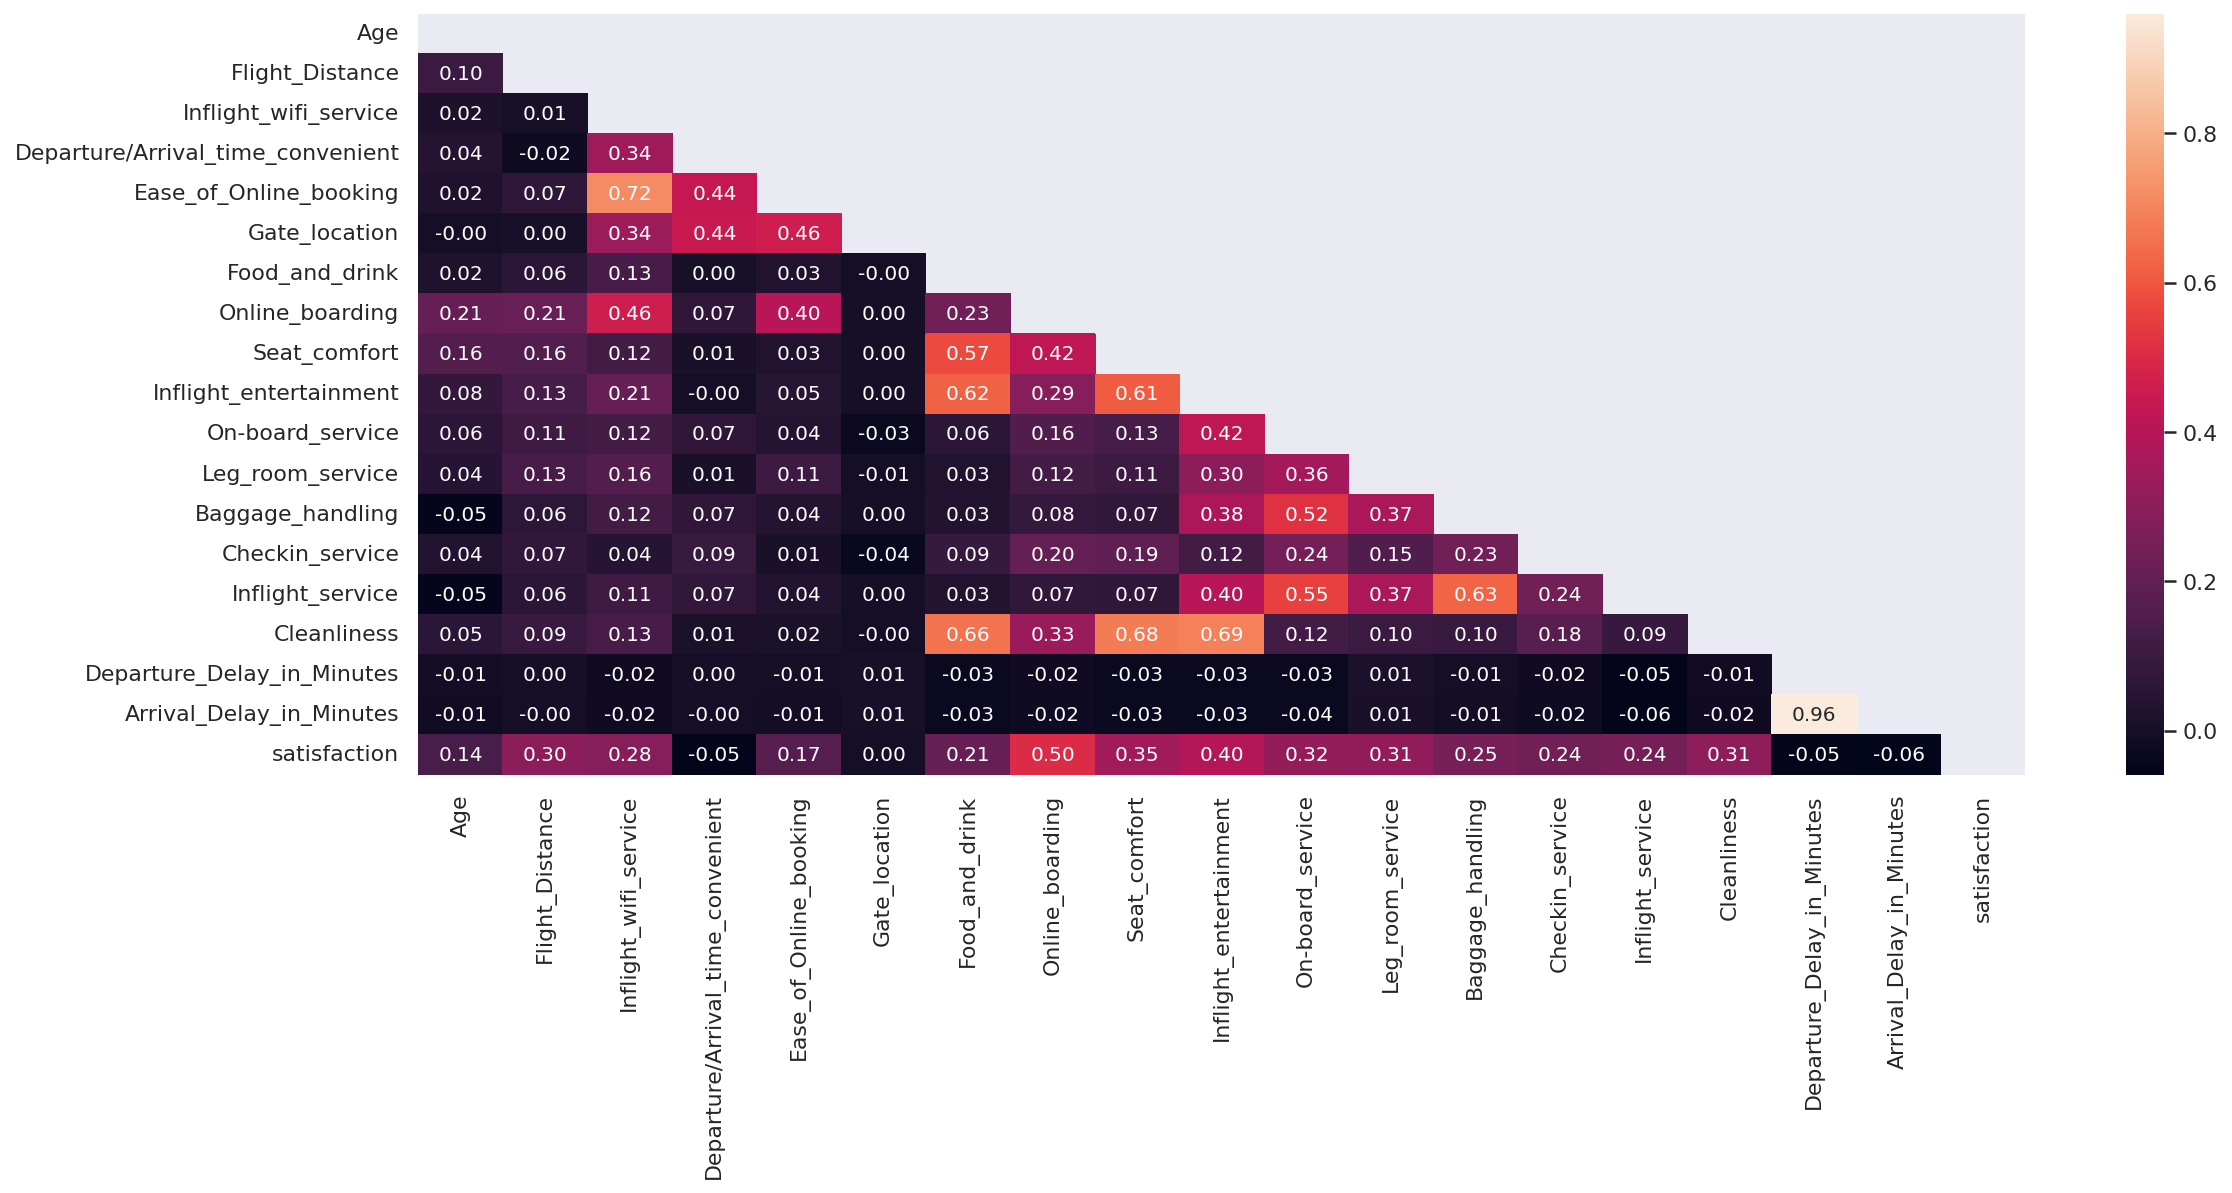

In [115]:
plt.figure(figsize = (18, 7))
mask = np.triu(np.ones_like(train.corr(), dtype = np.bool))
sns.heatmap(train.corr(), annot = True, mask = mask, fmt = '0.2f')
plt.show()

***=> 대부분의 service와 satisfaction 간 상관관계가 있어보인다.***

***=> 그 중 온라인보딩, 기내 엔터테인먼트, 좌석 편안함이 가장 중요해 보임***

***Arrival Delay in Minutes & Departure Delay in Minutes => 강한 상관관계***

In [116]:
train.corr()

,Age,Flight_Distance,Inflight_wifi_service,Departure/Arrival_time_convenient,Ease_of_Online_booking,Gate_location,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
Age,1.000000,0.099461,0.017859,0.038125,0.024842,-0.001330,0.023000,0.208939,0.160277,0.076444,0.057594,0.040583,-0.047529,0.035482,-0.049427,0.053611,-0.010152,-0.012105,0.137167
Flight_Distance,0.099461,1.000000,0.007131,-0.020043,0.065717,0.004793,0.056994,0.214869,0.157333,0.128740,0.109526,0.133916,0.063184,0.073072,0.057540,0.093149,0.002158,-0.002470,0.298780
Inflight_wifi_service,0.017859,0.007131,1.000000,0.343845,0.715856,0.336248,0.134718,0.456970,0.122658,0.209321,0.121500,0.160473,0.120923,0.043193,0.110441,0.132698,-0.017402,-0.019042,0.284245
Departure/Arrival_time_convenient,0.038125,-0.020043,0.343845,1.000000,0.436961,0.444757,0.004906,0.070119,0.011344,-0.004861,0.068882,0.012441,0.072126,0.093333,0.073318,0.014292,0.001005,-0.000918,-0.051601
Ease_of_Online_booking,0.024842,0.065717,0.715856,0.436961,1.000000,0.458655,0.031873,0.404074,0.030014,0.047032,0.038833,0.107601,0.038762,0.011081,0.035272,0.016179,-0.006371,-0.007947,0.171705
Gate_location,-0.001330,0.004793,0.336248,0.444757,0.458655,1.000000,-0.001159,0.001688,0.003669,0.003517,-0.028373,-0.005873,0.002313,-0.035427,0.001681,-0.003830,0.005467,0.005178,0.000682
Food_and_drink,0.023000,0.056994,0.134718,0.004906,0.031873,-0.001159,1.000000,0.234468,0.574556,0.622512,0.059073,0.032498,0.034746,0.087299,0.033993,0.657760,-0.029926,-0.032466,0.209936
Online_boarding,0.208939,0.214869,0.456970,0.070119,0.404074,0.001688,0.234468,1.000000,0.420211,0.285066,0.155443,0.123950,0.083280,0.204462,0.074573,0.331517,-0.018982,-0.021874,0.503557
Seat_comfort,0.160277,0.157333,0.122658,0.011344,0.030014,0.003669,0.574556,0.420211,1.000000,0.610590,0.131971,0.105559,0.074542,0.191854,0.069218,0.678534,-0.027898,-0.029735,0.349459
Inflight_entertainment,0.076444,0.128740,0.209321,-0.004861,0.047032,0.003517,0.622512,0.285066,0.610590,1.000000,0.420153,0.299692,0.378210,0.120867,0.404855,0.691815,-0.027489,-0.030597,0.398059


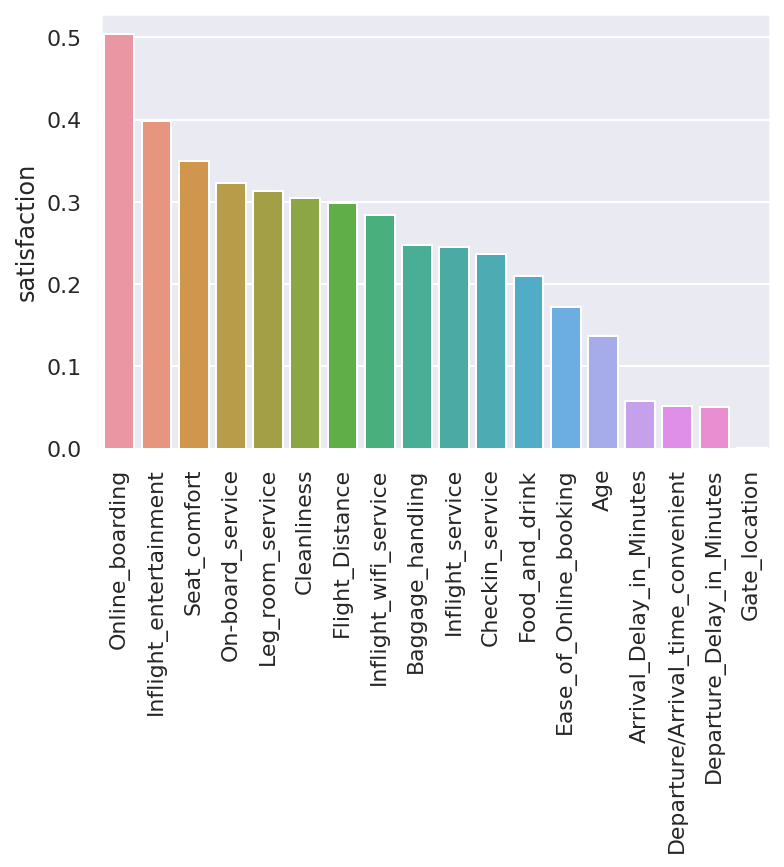

In [117]:
plt.xticks(rotation = 90)
sns.barplot(x = abs(train.corr()['satisfaction']).sort_values(ascending = False)[1:].index, y = abs(train.corr()['satisfaction']).sort_values(ascending = False)[1:])

### features 분포

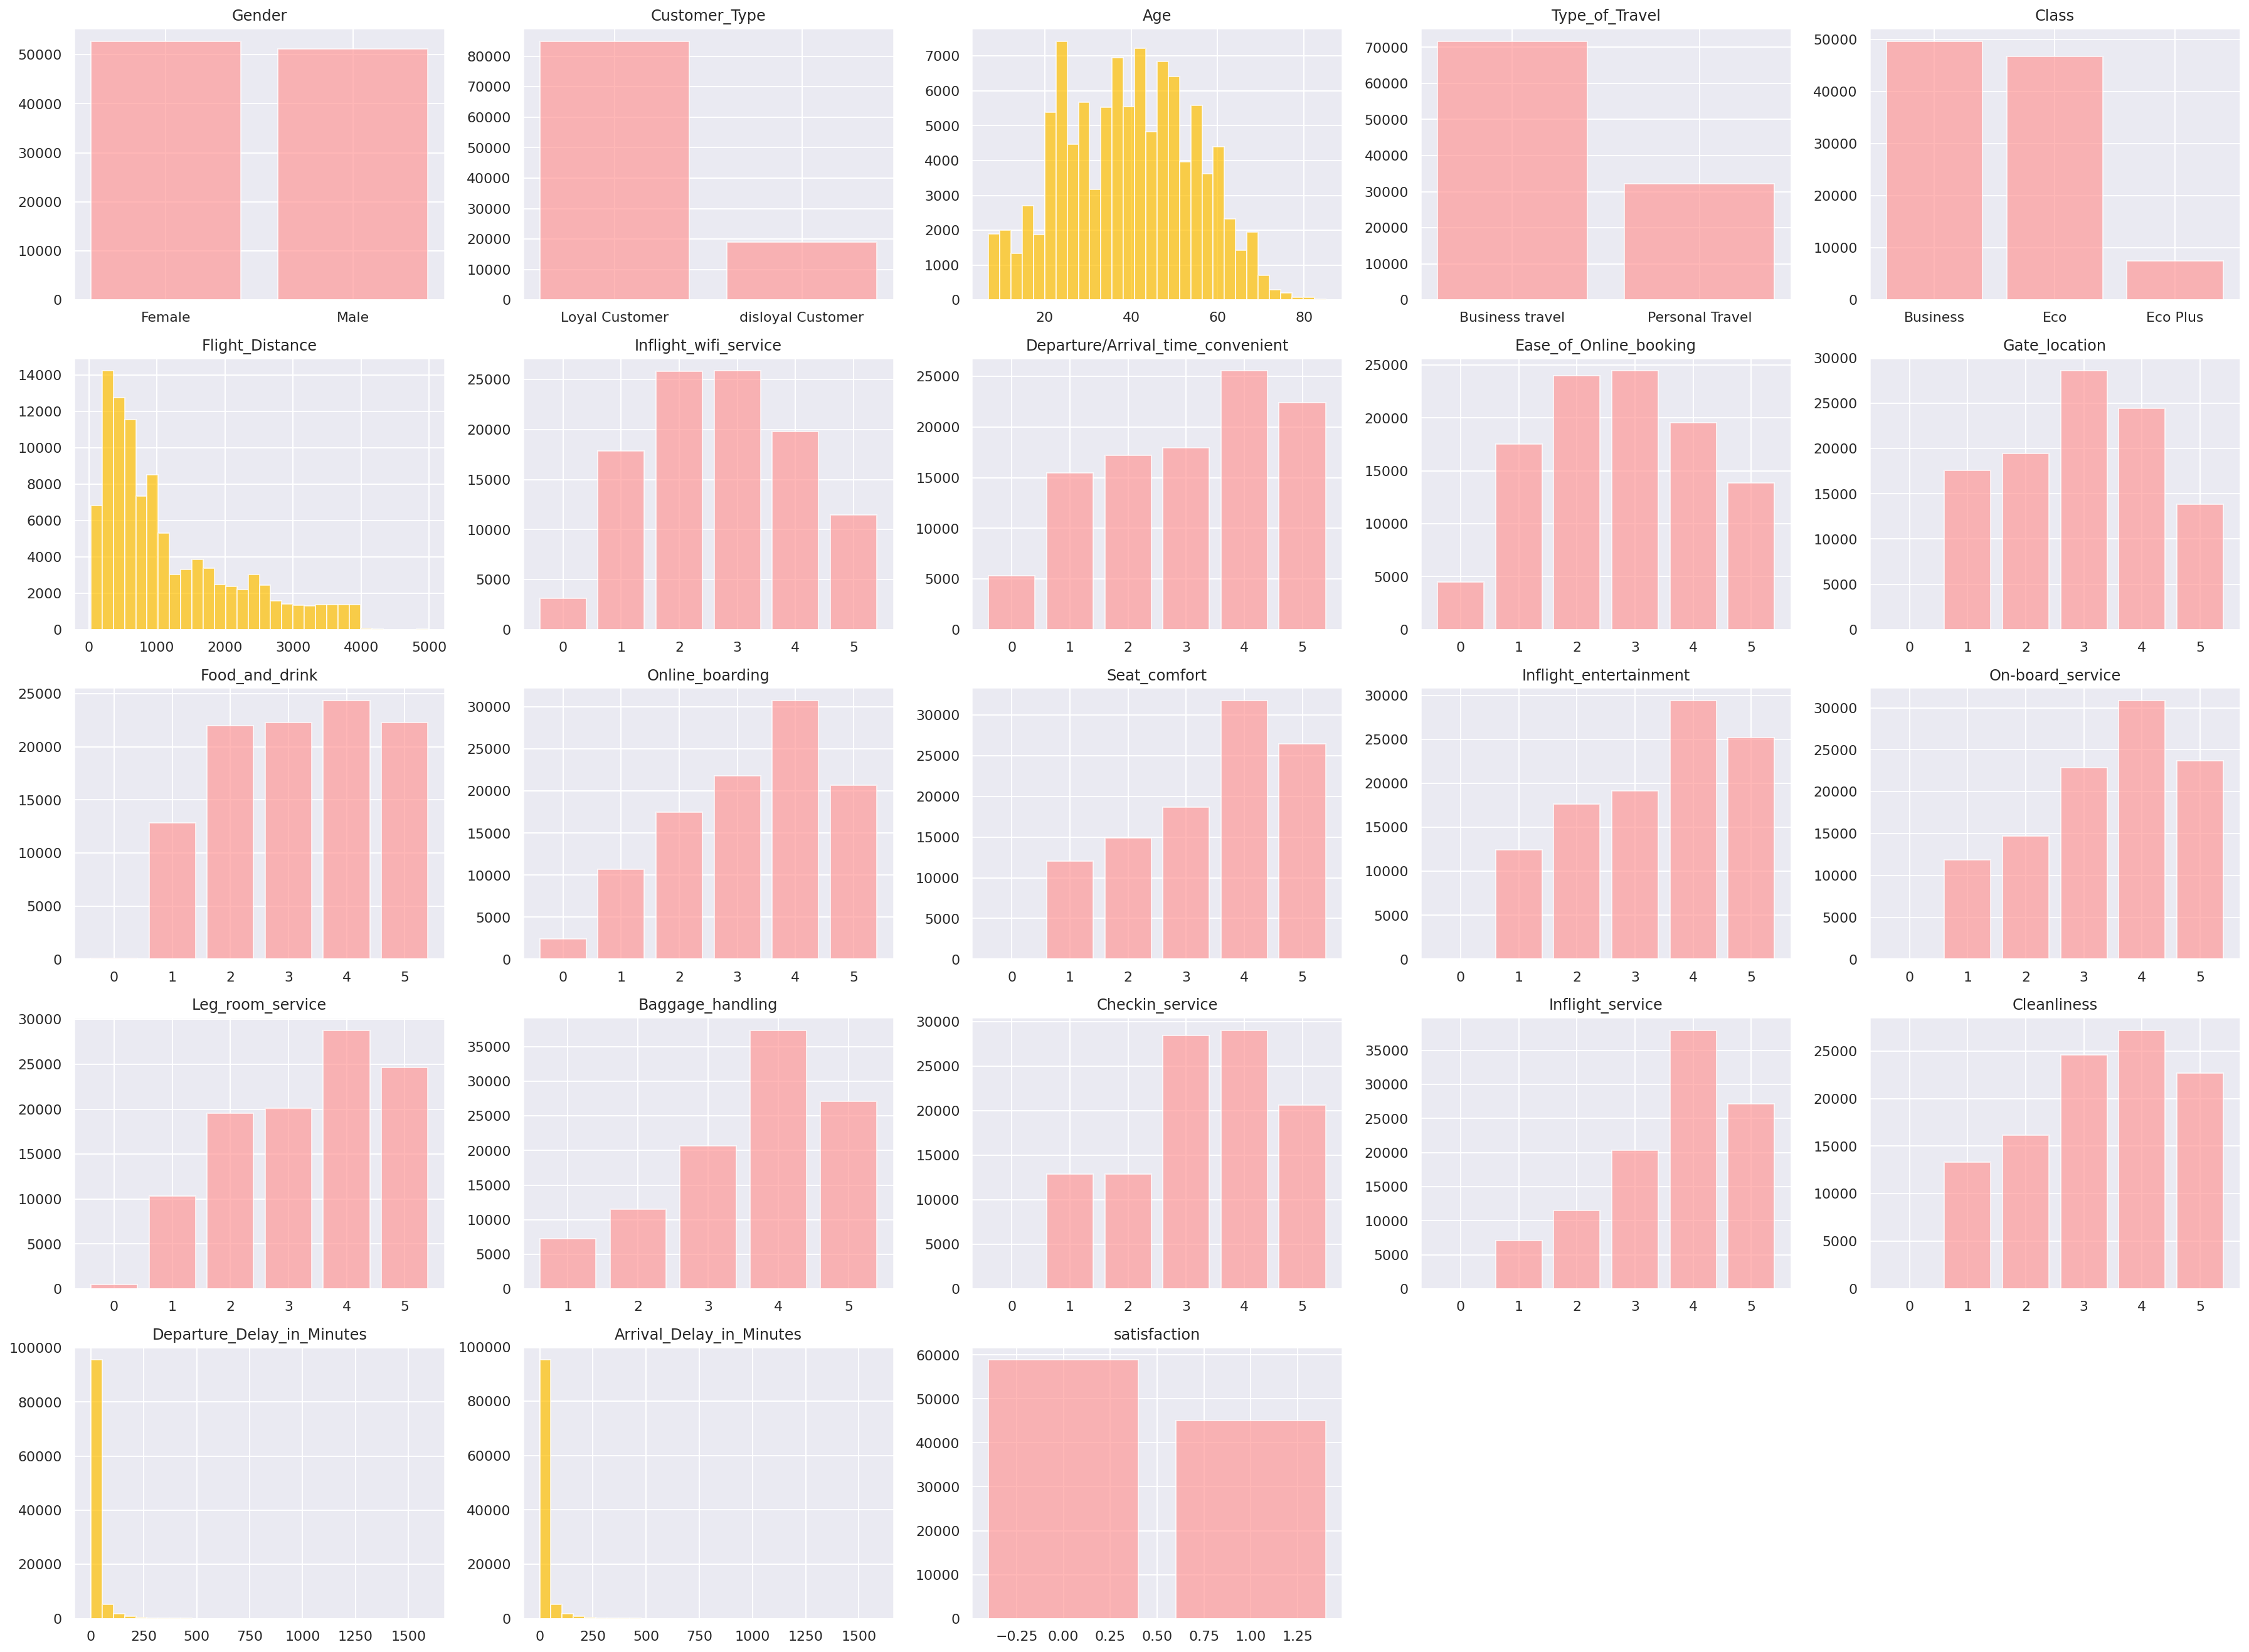

In [118]:
plt.figure(figsize = (25, 20))
for i in range(len(train.columns)):
  plt.subplot(5, 5, i + 1) # 최대 5 by 5, 25개의 특징 분포를 확인 가능
  plt.title(train.columns[i])
  if len(train[train.columns[i]].unique()) > 10: # 해당 특징의 고유한 값 종류가 10개가 넘으면 히스토그램으로 출력
    plt.hist(train[train.columns[i]], color = '#ffc000', bins = 30, alpha = 0.7) # bins는 칸을 나누는 값, alpha는 투명도
  else: # 해당 특징의 고유한 값 종류가 10개가 넘지 않으면 바플롯으로 출력
    plt.bar(train[train.columns[i]].value_counts().keys(), train[train.columns[i]].value_counts().values, color = '#ff9999', alpha = 0.7)
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

***-> 분홍 그래프가 그래프는 2개 혹은 5개의 값으로 이루어져 있음.***

***-> 노란 그래프는 연속된 값들***

***-> 노란 그래프에서 Age를 제외하고는 왼쪽으로 치우쳐저 있음을 확인할 수 있음***

### target과 feature들의 관계

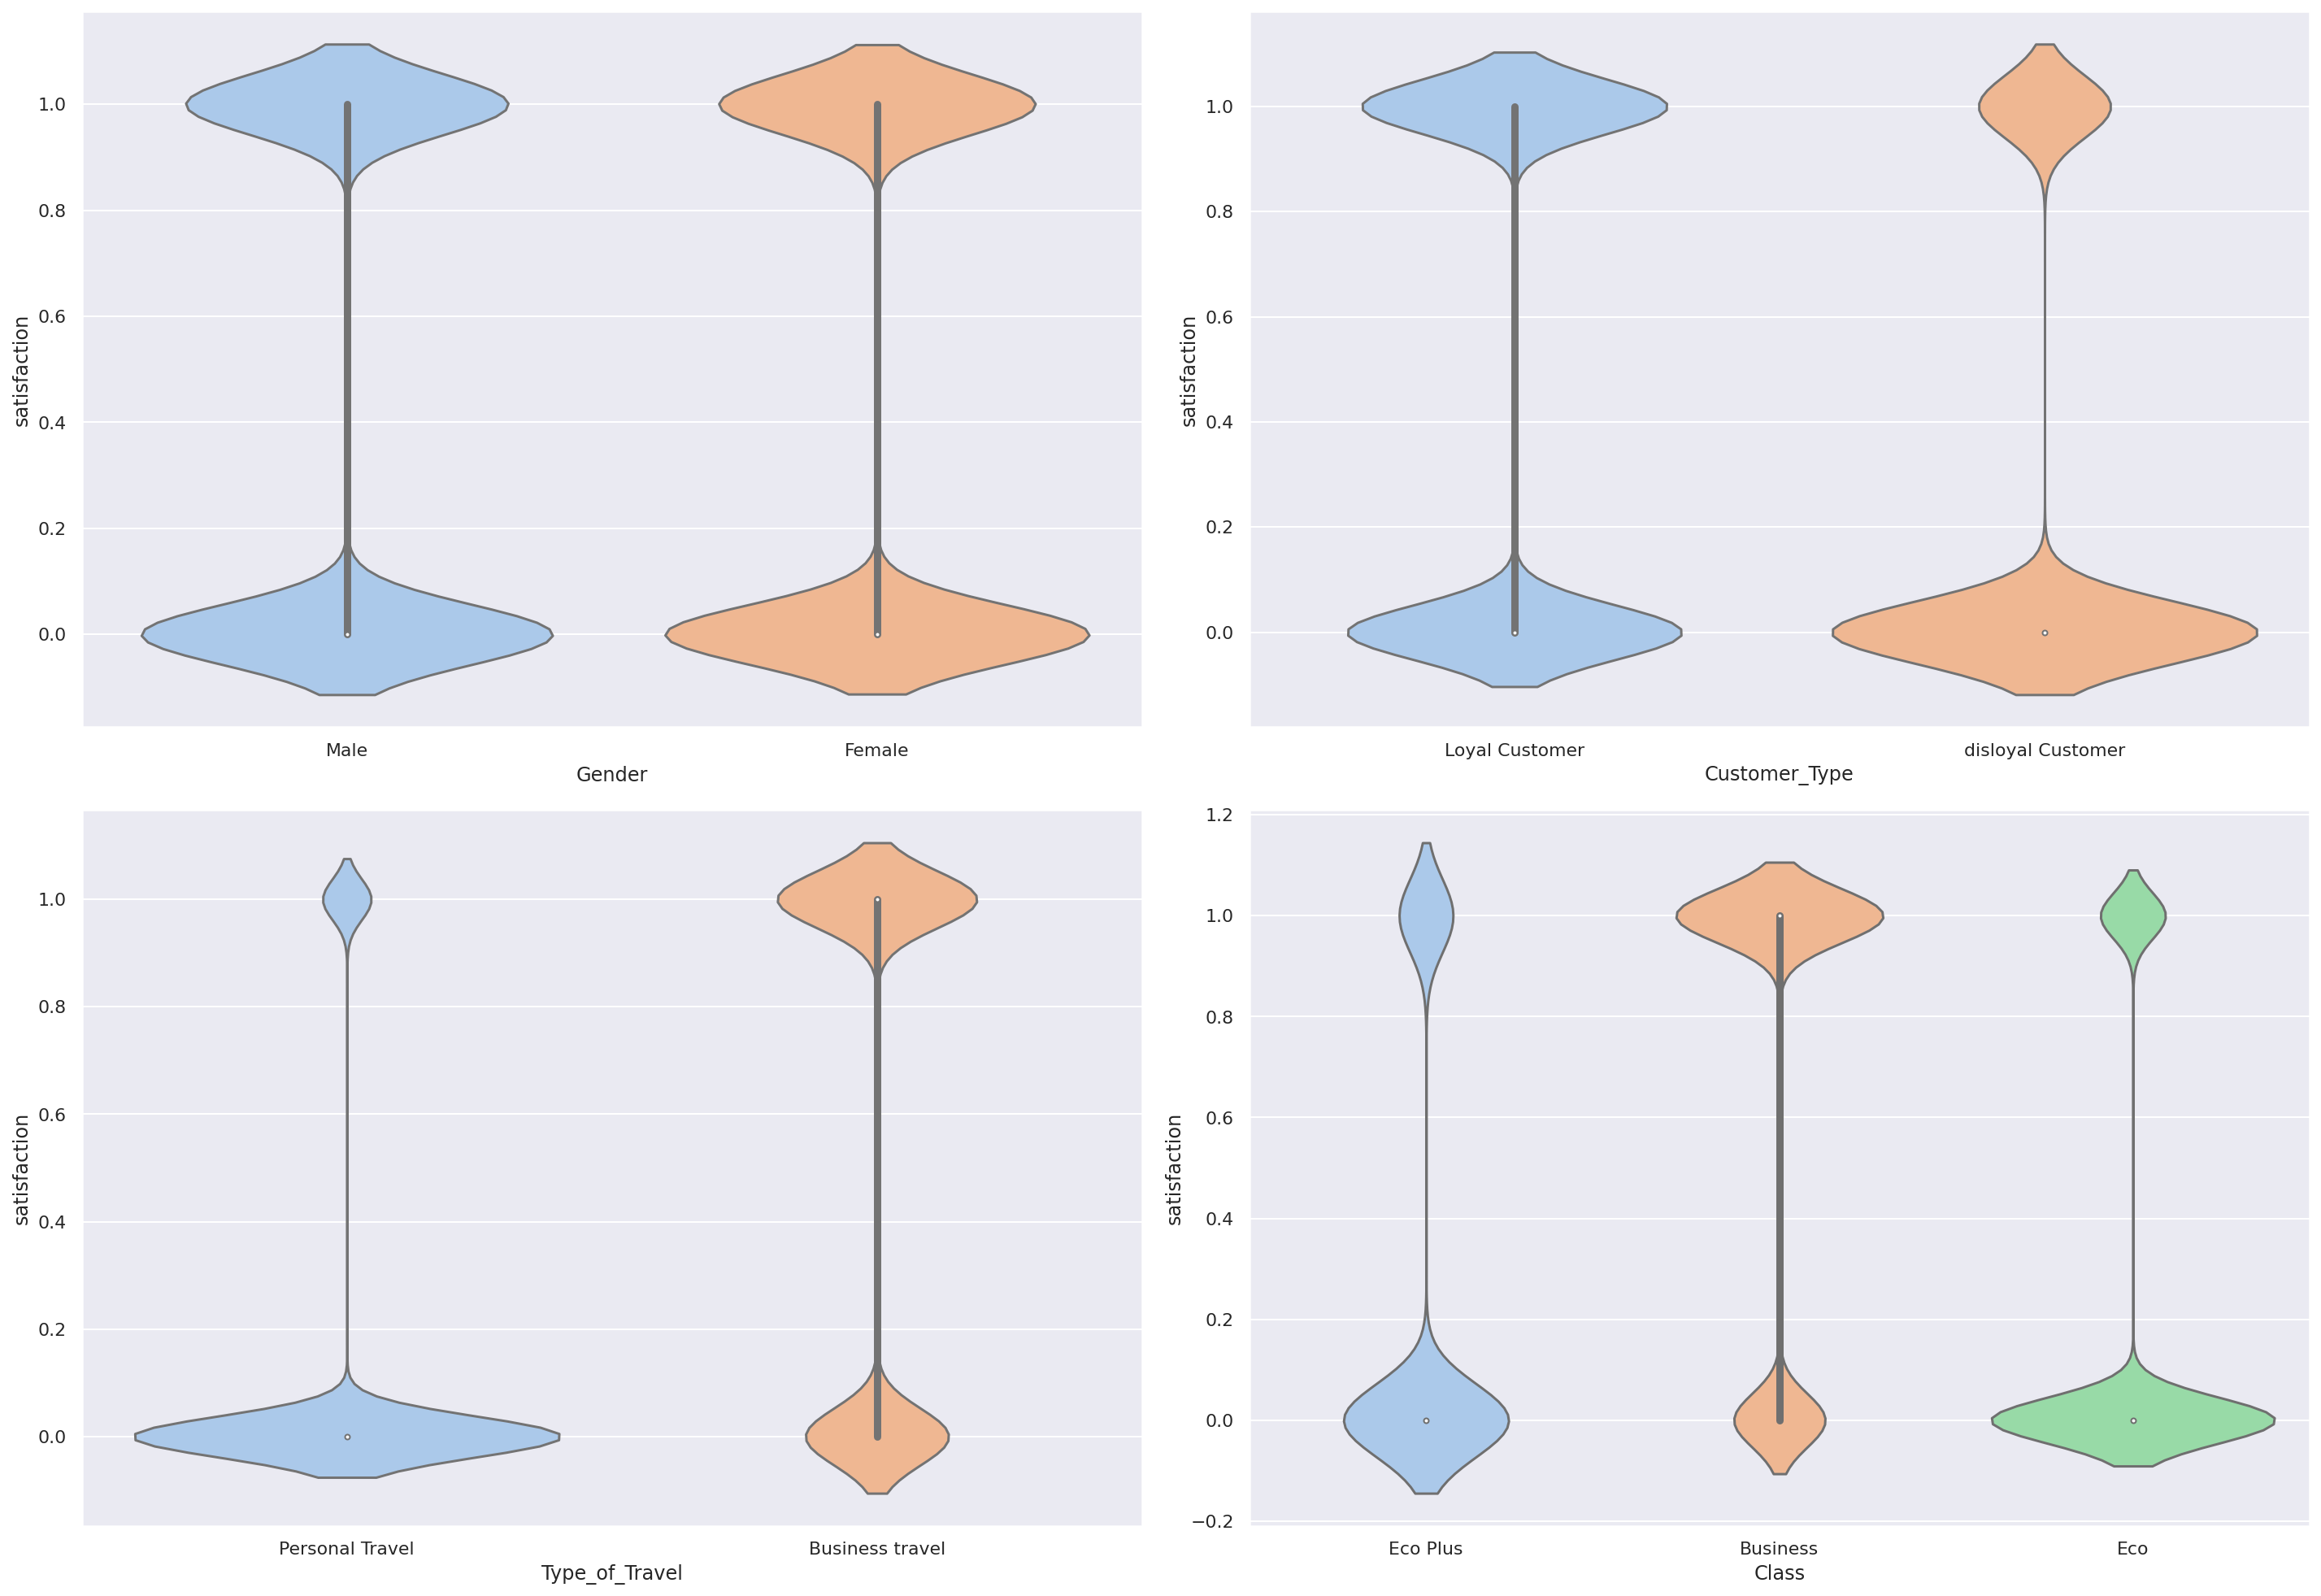

In [119]:
categorical_feature = train.columns[train.dtypes == 'object']

plt.figure(figsize = (20, 15))

for i in range(len(categorical_feature)):
  plt.subplot(2, 2, i + 1)
  plt.xlabel(categorical_feature[i])
  plt.ylabel('satisfaction')
  sns.set(palette = 'pastel')
  sns.violinplot(x = train[categorical_feature[i]], y = train['satisfaction'])
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

***target은 0(불만족)과 1(만족)로 이루어져 있다***

***=> Customer Type의 경우, 대부분의 disloyal customer는 항공기 이용에 불만족했다.***

***=> Type of Travel의 경우, 개인 여행은 대부분 불만족을 비즈니스 여행은 대부분 만족했다. why? 개인여행은 경비를 싸게 하기 위해 클래스 같은 서비스 부분을 저렴하게 이용한 반면 비즈니스 여행은 회사자금으로 이용하기 때문에 좋은 서비스를 받음(가설 반증)***

***=> Class의 경우, 비즈니스 클래스는 만족을 에코 클래스는 불만족했다.***

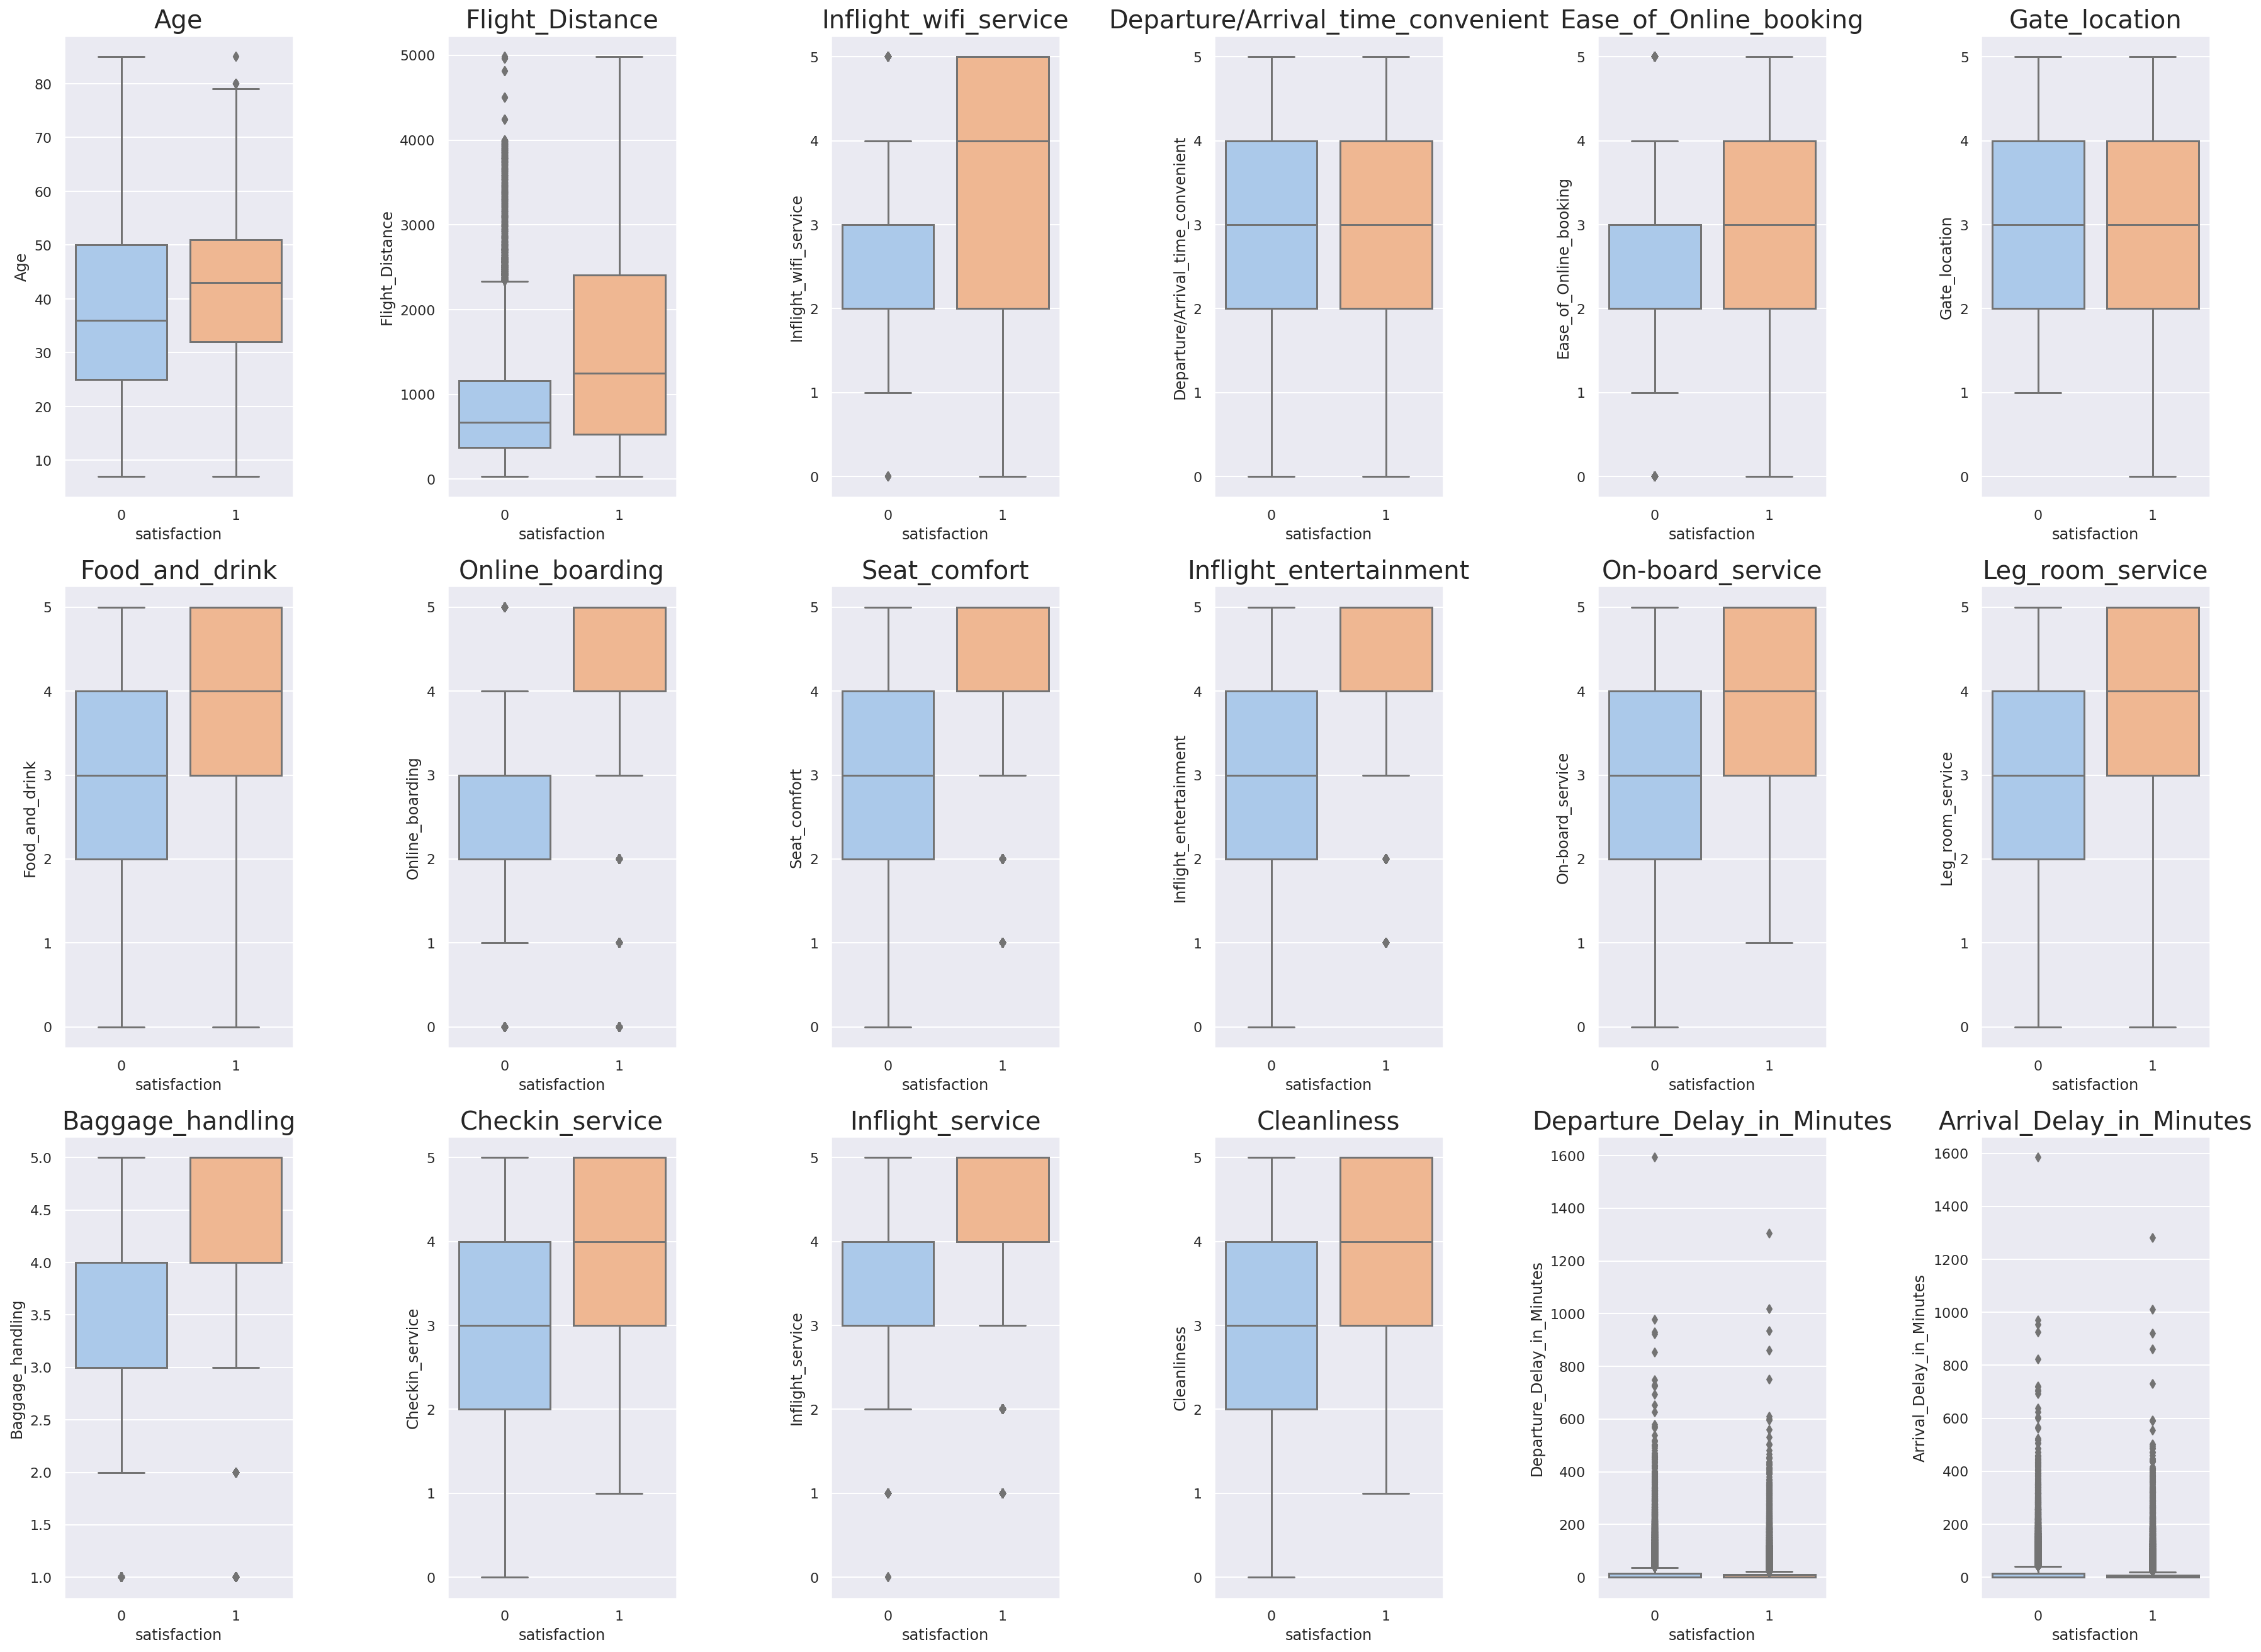

In [120]:
numeric_features = train.columns[(train.dtypes == 'int64') | (train.dtypes == 'float64')]

fig, axes = plt.subplots(3, 6, figsize = (25, 20))

for ax, col in zip(axes.flat, train[numeric_features].columns[:-1]):
  sns.boxplot(x = train['satisfaction'], y = col, ax = ax, data = train[numeric_features])
  ax.set_title(col, fontsize = 20)
plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()

***-> 박스들이 중간에 있을수록, 이상치가 없을수록 골고루 분포되어있는 것으로 해석할 수 있다.***

***=> 즉, target이 0이던 1이던 골고루 있다는 것은 그렇게 중요한 특징이 아니라는 것이다.***

***-> age, departure/arrival time convenient, gate location 등 별 연관이 없어 보인다.***

In [121]:
train.drop(['Age', 'Departure/Arrival_time_convenient', 'Gate_location'], axis = 1, inplace = True)
test.drop(['Age', 'Departure/Arrival_time_convenient', 'Gate_location'], axis = 1, inplace = True)

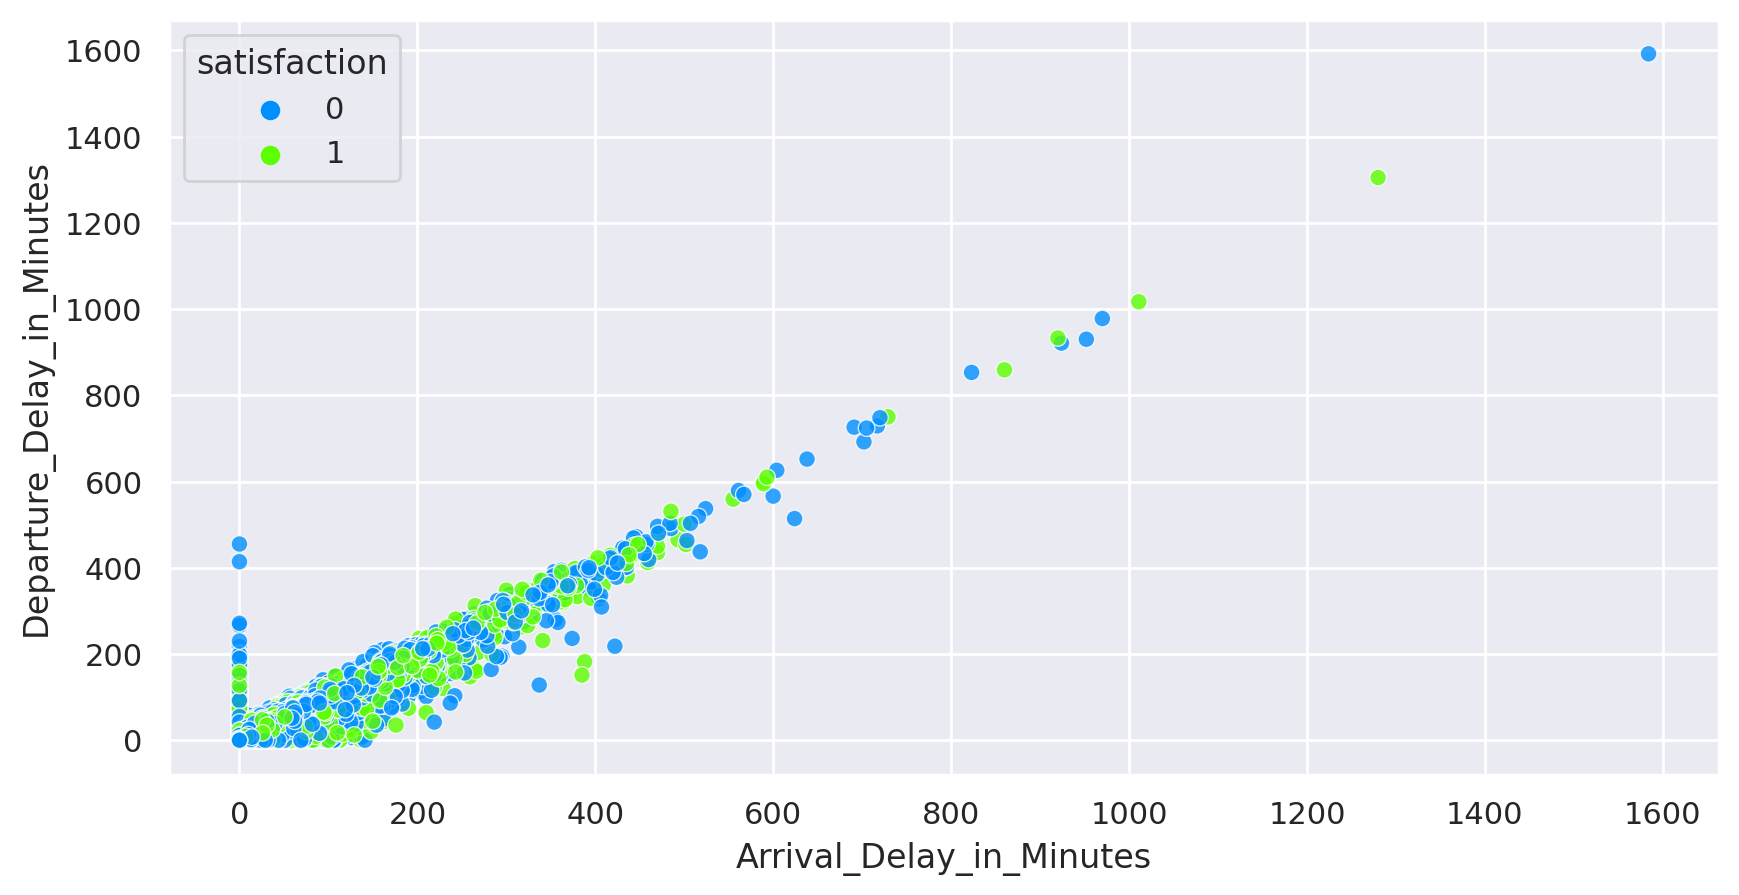

In [122]:
plt.figure(figsize = (10,5), dpi = 100)
sns.scatterplot(data = train, x = 'Arrival_Delay_in_Minutes', y = 'Departure_Delay_in_Minutes', hue = 'satisfaction', palette = 'gist_rainbow_r', alpha = 0.8)

***=> 출발과 도착 지연의 선형 관계***

***=> 1300분의 지연에도 만족하는 사람이 있다는 놀라운 사실 !***

In [123]:
train.groupby('Class').mean()

,Flight_Distance,Inflight_wifi_service,Ease_of_Online_booking,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
Class,,,,,,,,,,,,,,,,
Business,1675.976925,2.775315,2.913964,3.323165,3.716541,3.760858,3.635437,3.679472,3.644498,3.842907,3.519178,3.844579,3.477600,14.398067,14.538528,0.694251
Eco,743.439748,2.675067,2.605241,3.086277,2.812985,3.138838,3.098256,3.120355,3.085720,3.450551,3.122002,3.463921,3.108097,15.160509,15.621222,0.186138
Eco Plus,747.125567,2.767948,2.661996,3.122631,2.889245,3.183747,3.141713,3.047638,3.061382,3.363758,3.017214,3.388444,3.130771,15.431545,16.032826,0.246064


***=> 일반적으로 비즈니스 클래스가 이코노미 플러스와 이코노미 클래스보다 더 만족***

***=> 비즈니스 클래스의 사람들은 제공되는 모든 서비스에 대해 에코 및 에코 플러스에 비해 더 높은 평가를 한다. 여행의 '클래스'는 만족도의 큰 요소가 되어야 한다.(가설 반증)***

### 범주형 특성 라벨인코딩

In [124]:
train.dtypes == 'object'

Gender                         True
Customer_Type                  True
Type_of_Travel                 True
Class                          True
Flight_Distance               False
Inflight_wifi_service         False
Ease_of_Online_booking        False
Food_and_drink                False
Online_boarding               False
Seat_comfort                  False
Inflight_entertainment        False
On-board_service              False
Leg_room_service              False
Baggage_handling              False
Checkin_service               False
Inflight_service              False
Cleanliness                   False
Departure_Delay_in_Minutes    False
Arrival_Delay_in_Minutes      False
satisfaction                  False
dtype: bool

In [125]:
for col in train.select_dtypes(include=['object']).columns:
      print(col , " : " , train[col].unique())
##원핫인코딩보다는 라벨인코딩이 낫다고 판단

Gender  :  ['Male' 'Female']
Customer_Type  :  ['Loyal Customer' 'disloyal Customer']
Type_of_Travel  :  ['Personal Travel' 'Business travel']
Class  :  ['Eco Plus' 'Business' 'Eco']


In [126]:
for col in test.select_dtypes(include=['object']).columns:
      print(col , " : " , test[col].unique())

Gender  :  ['Female' 'Male']
Customer_Type  :  ['Loyal Customer' 'disloyal Customer']
Type_of_Travel  :  ['Business travel' 'Personal Travel']
Class  :  ['Eco' 'Business' 'Eco Plus']
satisfaction  :  ['satisfied' 'neutral or dissatisfied']


In [127]:
test.dtypes == 'object'

Gender                         True
Customer_Type                  True
Type_of_Travel                 True
Class                          True
Flight_Distance               False
Inflight_wifi_service         False
Ease_of_Online_booking        False
Food_and_drink                False
Online_boarding               False
Seat_comfort                  False
Inflight_entertainment        False
On-board_service              False
Leg_room_service              False
Baggage_handling              False
Checkin_service               False
Inflight_service              False
Cleanliness                   False
Departure_Delay_in_Minutes    False
Arrival_Delay_in_Minutes      False
satisfaction                   True
dtype: bool

In [128]:
def categorical_encoding(df):
  lencoders = {}
  for col in df.select_dtypes(include=['object']).columns:
      lencoders[col] = LabelEncoder()
      df[col] = lencoders[col].fit_transform(df[col])

In [129]:
categorical_encoding(train)
categorical_encoding(test)

In [130]:
train.head()

,Gender,Customer_Type,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Ease_of_Online_booking,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,1,0,1,2,460,3,3,5,3,5,5,4,3,4,4,5,5,25,18.0,0
1,1,1,0,0,235,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,0
2,0,0,0,0,1142,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,1
3,0,0,0,0,562,2,5,2,2,2,2,2,5,3,1,4,2,11,9.0,0
4,1,0,0,0,214,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,1


In [131]:
test.head()

,Gender,Customer_Type,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Ease_of_Online_booking,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
0,0,0,0,1,160,5,3,3,4,3,5,5,5,5,2,5,5,50,44.0,1
1,0,0,0,0,2863,1,3,5,4,5,4,4,4,4,3,4,5,0,0.0,1
2,1,1,0,1,192,2,2,2,2,2,2,4,1,3,2,2,2,0,0.0,0
3,1,0,0,0,3377,0,0,3,4,4,1,1,1,1,3,1,4,0,6.0,1
4,0,0,0,1,1182,2,4,4,1,2,2,2,2,2,4,2,4,0,20.0,1


### 이상치

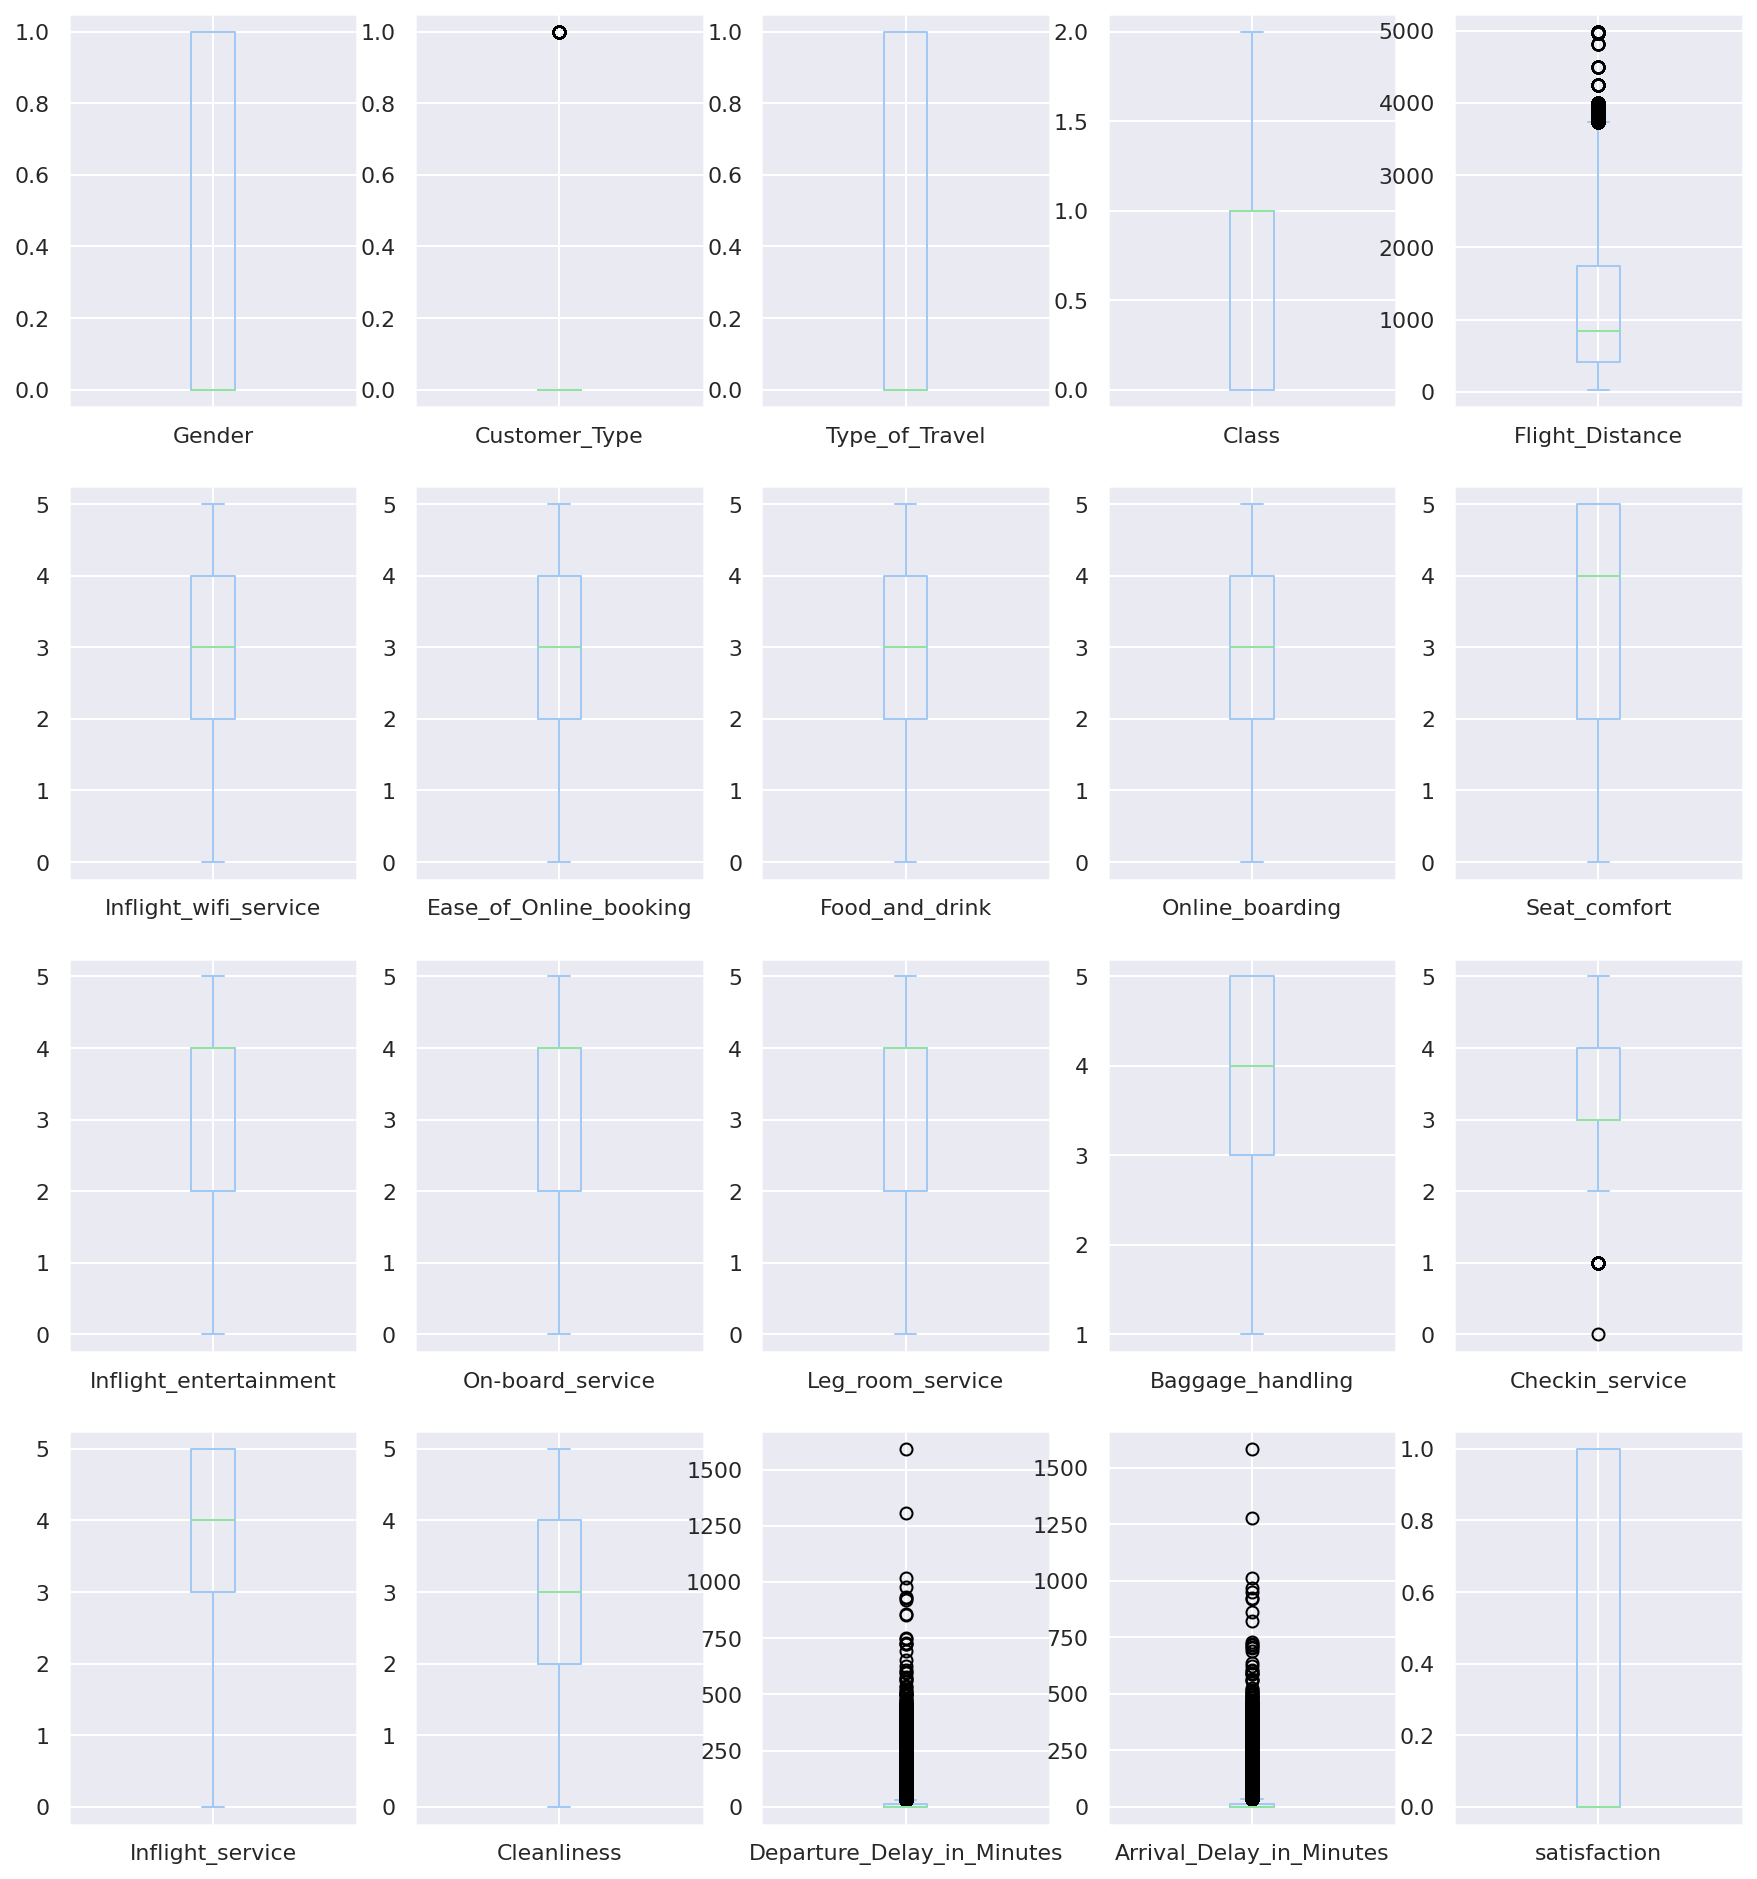

In [132]:
train.plot(kind = "box", subplots = True, layout = (5, 5), figsize = (15, 21))
plt.show()

***=> 출발/도착 지연시간에 대해서 이상치가 매우 많다***

***이상치 있는 컬럼 : arrival delay in minutes, checkin service, flight distance***

In [133]:
train.describe()

,Gender,Customer_Type,Type_of_Travel,Class,Flight_Distance,Inflight_wifi_service,Ease_of_Online_booking,Food_and_drink,Online_boarding,Seat_comfort,Inflight_entertainment,On-board_service,Leg_room_service,Baggage_handling,Checkin_service,Inflight_service,Cleanliness,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes,satisfaction
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000
mean,0.492541,0.182678,0.310373,0.594135,1189.448375,2.729683,2.756901,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.133392,0.433333
std,0.499947,0.386404,0.462649,0.620799,997.147281,1.327829,1.398929,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.649776,0.495538
min,0.000000,0.000000,0.000000,0.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,843.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000
max,1.000000,1.000000,1.000000,2.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000,1.000000


***데이터의 개수 똑같고, 각 컬럼 속성에 맞게 min, max 적절하다고 판단. -> 이상치 제거 필요 X 판단***

### Train/Val

In [134]:
target = 'satisfaction'
train, val = train_test_split(train, train_size = 0.80, test_size = 0.20, stratify = train[target], random_state = 2)

In [135]:
X_train = train.drop(columns = target)
y_train = train[target]
X_val = val.drop(columns = target)
y_val = val[target]
X_test = test.drop(columns = target)
y_test = test[target]

### 정규화

In [136]:
##standardization => 1-5 구간처럼 좁은 구간도 있지만 0-1592구간처럼 넓은 구간이 있어 스케일링할 필요가 있다고 판단
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### 특성선택

In [137]:
selector = SelectKBest(score_func = f_regression, k = 5)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)
X_train_selected.shape, X_val_selected.shape

((83123, 5), (20781, 5))

In [138]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask] 

print('Top 5 Features : ', selected_names)

Top 10 Features :  Index(['Type_of_Travel', 'Class', 'Online_boarding', 'Seat_comfort',
       'Inflight_entertainment'],
      dtype='object')



### 특성중요도

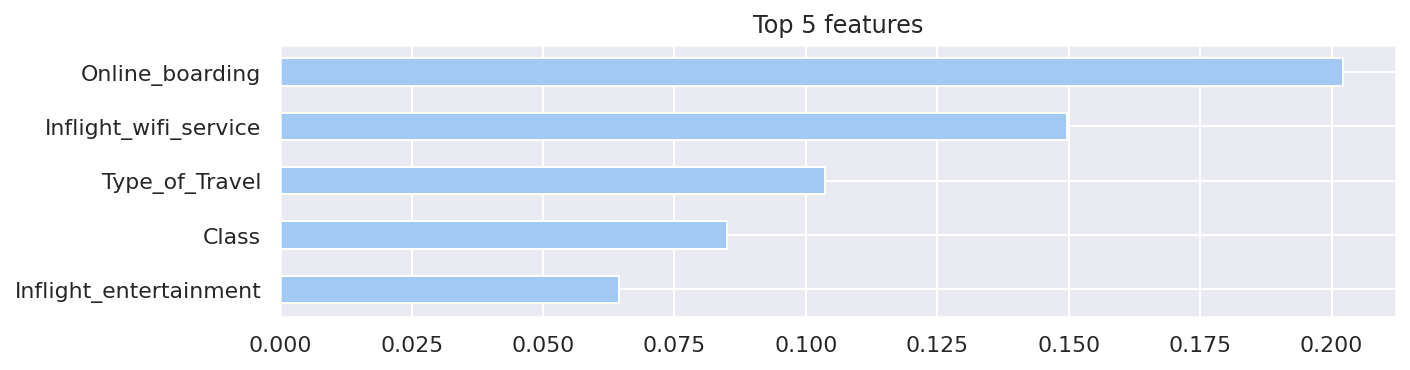

In [139]:
##트리기반일 땐 Select K Best를 사용할 필요가 없는 이유
##SelectFromModel을 함께 사용하면 불순도를 낮추는 데 중요하게 기여하는 특성을 계산하고, SelectFromModel을 관계없는 특성을 버린다고 한다. 
##랜덤포레스트 모델에서는 무작위로 샘플을 만들기 때문에, 상관관계가 있는 feature의 중요성이 실제보다 더 낮게 보일 수 있다.
rf = RandomForestClassifier(n_estimators = 100, random_state = 2, n_jobs = -1)
selector = SelectFromModel(rf)
selector.fit(X_train_scaled, y_train)
selector.get_support()

selected_feat = X_train.columns[(selector.get_support())]

importances = pd.Series(rf.fit(X_train, y_train).feature_importances_, X_train.columns)

n = len(selected_feat)
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [140]:
feature_importance = pd.DataFrame(rf.fit(X_train_scaled, y_train).feature_importances_, X_train.columns)

In [141]:
feature_importance.sort_values(0, ascending = False).head(5)

,0
Online_boarding,0.202166
Inflight_wifi_service,0.149574
Type_of_Travel,0.103556
Class,0.085028
Inflight_entertainment,0.064423


### 순열중요도

In [142]:
permuter = PermutationImportance(rf.fit(X_train_scaled, y_train), random_state = 2)

permuter.fit(X_train_scaled, y_train)

PermutationImportance(estimator=RandomForestClassifier(n_jobs=-1,
                                                       random_state=2),
                      random_state=2)

In [143]:
pd.Series(permuter.feature_importances_, X_train.columns.tolist()).sort_values(ascending = False).head(5)

Type_of_Travel           0.167335
Inflight_wifi_service    0.153065
Customer_Type            0.062211
Online_boarding          0.058333
Baggage_handling         0.037359
dtype: float64

In [144]:
eli5.show_weights(permuter, top = None, feature_names = X_train.columns.tolist())

Weight,Feature
0.1673 ± 0.0019,Type_of_Travel
0.1531 ± 0.0016,Inflight_wifi_service
0.0622 ± 0.0011,Customer_Type
0.0583 ± 0.0014,Online_boarding
0.0374 ± 0.0014,Baggage_handling
0.0371 ± 0.0014,Checkin_service
0.0368 ± 0.0008,Seat_comfort
0.0337 ± 0.0008,Inflight_service
0.0280 ± 0.0009,Class
0.0279 ± 0.0009,Cleanliness


***=> 전체적으로 important한 features***
* ***'Online_boarding'***
* ***'Inflight_wifi_service'***
* ***'Type_of_Travel'***
* ***'Class'***
* ***'Inflight_entertainment'***
* ***'Seat_comfort'***
* ***'Customer_Type'***
* ***'Baggage_handling'***


## Modeling

In [145]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [146]:
! pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [147]:
import time
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, plot_roc_curve, classification_report, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import catboost as cb
from scipy import stats
from pdpbox.pdp import pdp_isolate, pdp_plot
import shap

In [149]:
features = ['Online_boarding', 'Inflight_wifi_service', 'Type_of_Travel', 'Class', 'Inflight_entertainment', 'Seat_comfort', 'Customer_Type', 'Baggage_handling']

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [150]:
def run_model(model, X_train, y_train, X_val, y_val, verbose=True):
    t0 = time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred) 
    time_taken = time.time() - t0

    print('훈련 정확도', model.score(X_train, y_train))
    print('검증 정확도', model.score(X_val, y_val))
    print("Accuracy = {}".format(accuracy)) #위랑 같은 부분
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_val,y_pred,digits=5))
    plot_confusion_matrix(model, X_val, y_val,cmap=plt.cm.pink, normalize = 'all')
    plot_roc_curve(model, X_val, y_val)

    return model, accuracy, roc_auc, time_taken

### 1차 모델링 (Logistic Regression)

**Logistic regression**

훈련 정확도 0.8557679583268168
검증 정확도 0.8597276358211828
Accuracy = 0.8597276358211828
ROC Area under Curve = 0.8563195426227579
Time taken = 2.0129106044769287
              precision    recall  f1-score   support

           0    0.87203   0.88188   0.87693     11776
           1    0.84321   0.83076   0.83694      9005

    accuracy                        0.85973     20781
   macro avg    0.85762   0.85632   0.85693     20781
weighted avg    0.85954   0.85973   0.85960     20781



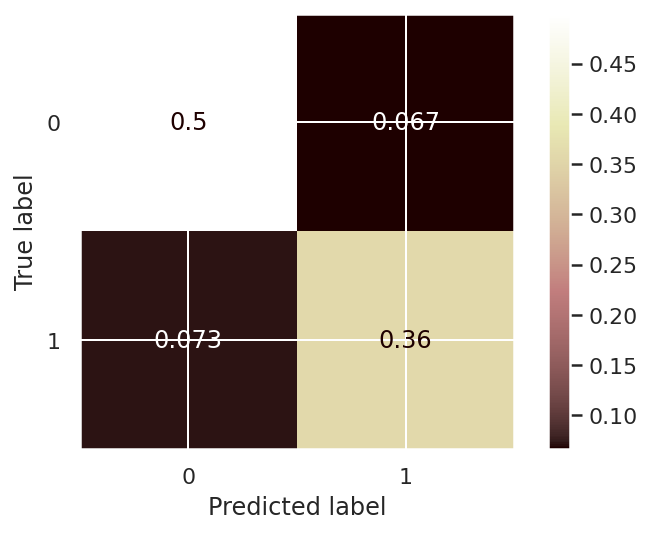

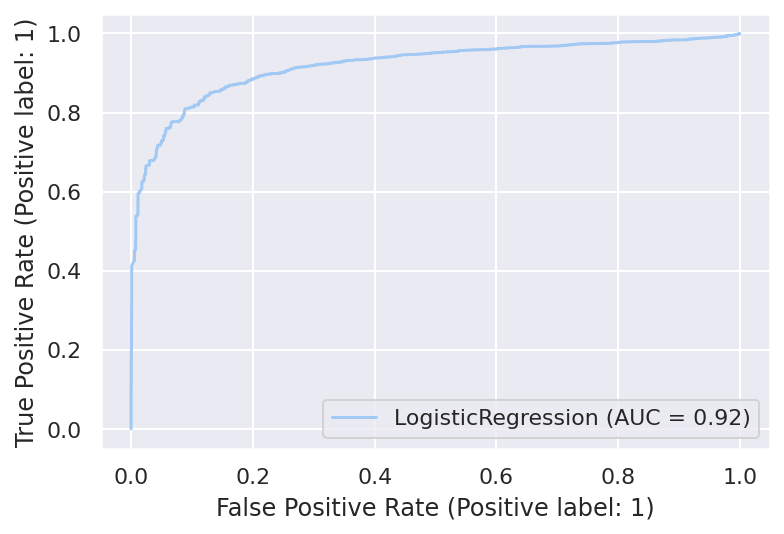

In [151]:
model_lr = LogisticRegression(n_jobs = -1, random_state = 2)
model_lr, accuracy_lr, roc_auc_lr, tt_lr = run_model(model_lr, X_train_scaled, y_train, X_val_scaled, y_val)

***logistic regression를 이용하여 Parameter없이 간단히 1차 Baseline Modeling을 진행***

***검증 Set에서의 정확도(0.8597276358211828)가 최빈값 baseline(0.567)을 넘었으므로 이번 Modeling에서 유심히 볼 평가지표인 ‘AUC Score’를 Baseline(0.8563195426227579)으로 두고 진행***

***정확도, 정밀도와 재현율이 포함된 F1도 함께 확인하며 진행하지만 신호탐지이론에서 적중확률 대 오경보확률의 그래프를 점수화 한 AUC Score를 중점으로 두고 진행***

***=> 0.8563195426227579 (기본 모델)***

### 2차 모델링 (XGBoost)

**XGBoost**

훈련 정확도 0.9322931078040976
검증 정확도 0.9334488234444925
Accuracy = 0.9334488234444925
ROC Area under Curve = 0.9306697111583541
Time taken = 4.141271352767944
              precision    recall  f1-score   support

           0    0.93243   0.95151   0.94187     11776
           1    0.93485   0.90983   0.92217      9005

    accuracy                        0.93345     20781
   macro avg    0.93364   0.93067   0.93202     20781
weighted avg    0.93348   0.93345   0.93333     20781



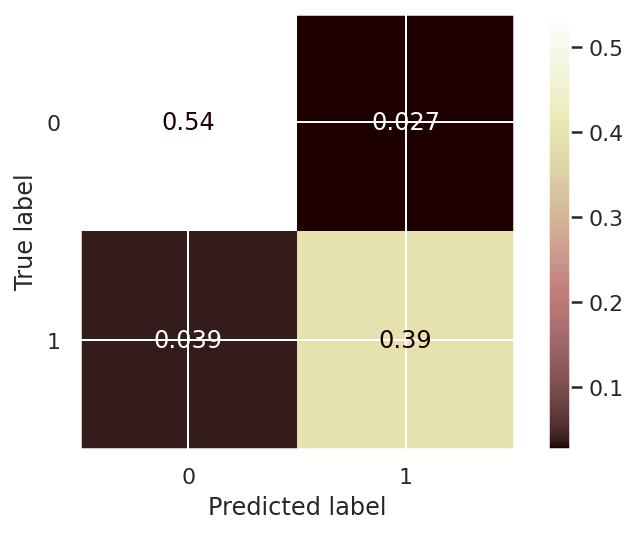

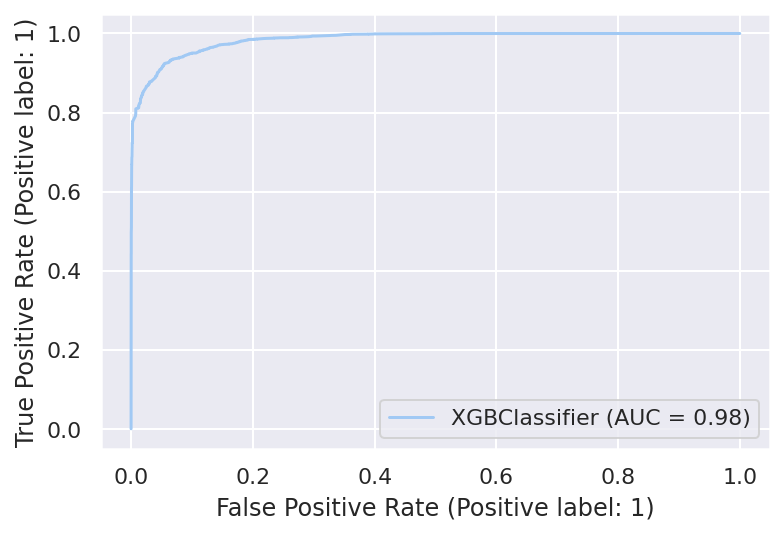

In [152]:
params_xgb = {}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, tt_xgb = run_model(model_xgb, X_train_scaled, y_train, X_val_scaled, y_val)

***RandomForest를 사용했을 때보다 조금 올랐다.***

***=> 0.9306697111583541***

**하이퍼파라미터 튜닝(수동)**

훈련 정확도 0.9510965677369682
검증 정확도 0.9478850873393966
Accuracy = 0.9478850873393966
ROC Area under Curve = 0.9451582557923737
Time taken = 3.882946491241455
              precision    recall  f1-score   support

           0    0.94373   0.96561   0.95454     11776
           1    0.95362   0.92471   0.93894      9005

    accuracy                        0.94789     20781
   macro avg    0.94867   0.94516   0.94674     20781
weighted avg    0.94802   0.94789   0.94778     20781



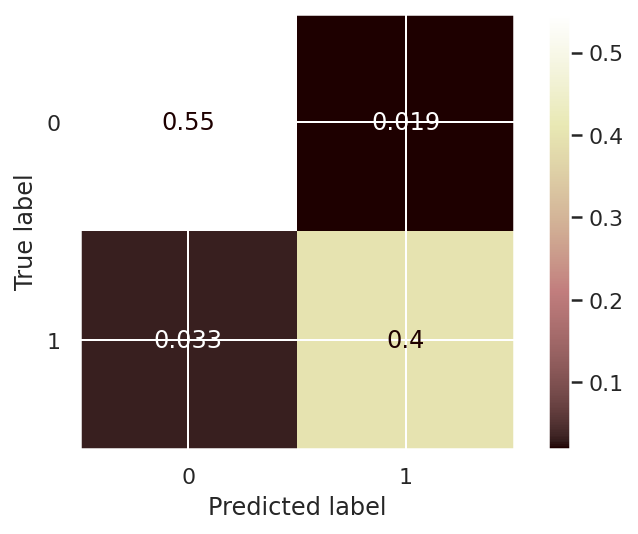

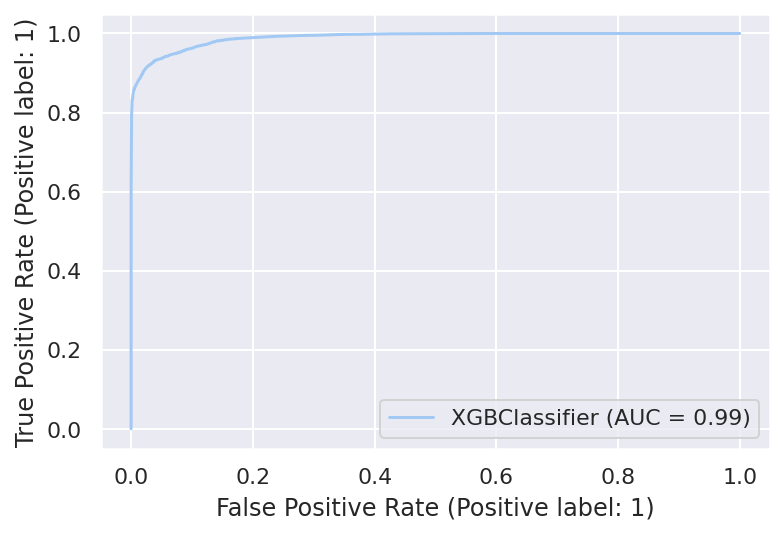

In [153]:
params_xgb = {'n_estimators': 10, 'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, tt_xgb = run_model(model_xgb, X_train_scaled, y_train, X_val_scaled, y_val)

***성능이 더 좋아졌다 !***

***=> 0.9451582557923737***

**GridSearchCV**

In [155]:
model_xgb = xgb.XGBClassifier()
param_grid={'booster' :['gbtree'],
                 'max_depth':[5,6,8],
                 'min_child_weight':[1,3,5],
                 'gamma':[0,1,2,3],
                 'nthread':[4],
                 'colsample_bytree':[0.5,0.8],
                 'colsample_bylevel':[0.9],
                 'n_estimators':[50],
                 'objective':['binary:logistic'],
                 'random_state':[2]}
grid_cv_xgb = GridSearchCV(model_xgb, param_grid = param_grid, n_jobs = -1)
grid_cv_xgb.fit(X_train_scaled, y_train)
print('best parameters : \n', grid_cv_xgb.best_params_)

best parameters : 
 {'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'gamma': 0, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 50, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 2}


**Best parameters 적용 Modeling**

훈련 정확도 0.9461520878697833
검증 정확도 0.9450940763197151
Accuracy = 0.9450940763197151
ROC Area under Curve = 0.9425127033517009
Time taken = 3.668576240539551
              precision    recall  f1-score   support

           0    0.94242   0.96187   0.95205     11776
           1    0.94876   0.92315   0.93578      9005

    accuracy                        0.94509     20781
   macro avg    0.94559   0.94251   0.94391     20781
weighted avg    0.94517   0.94509   0.94500     20781



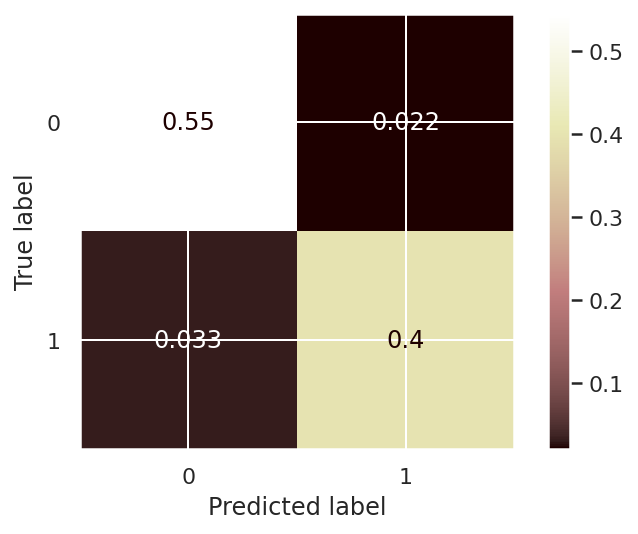

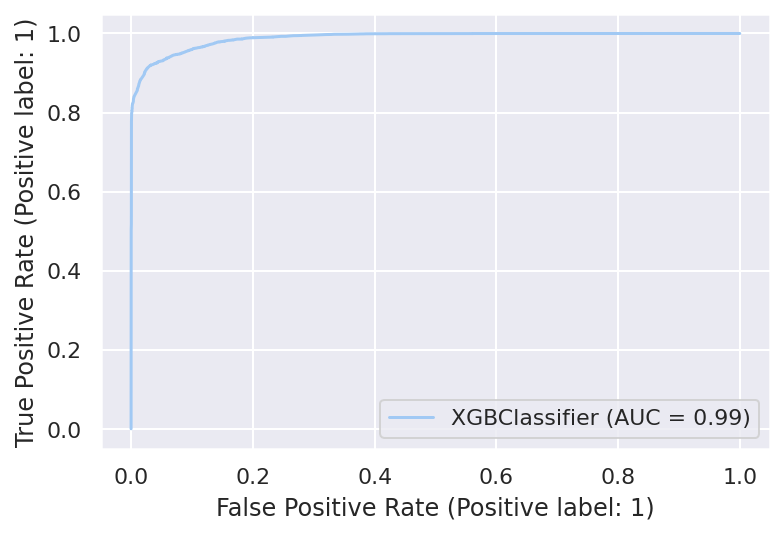

In [156]:
params_xgb = {'booster': 'gbtree', 'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'gamma': 1, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 50, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 2}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, tt_xgb = run_model(model_xgb, X_train_scaled, y_train, X_val_scaled, y_val)

***=> 0.9425127033517009***

**하이퍼파라미터 튜닝(수동)(0.9451582557923737*) > GridSearchCV(0.9425127033517009)**

### 최종 모델링 (XGBoost, hyperparameter tuning 수동)

**하이퍼파라미터 튜닝(수동) -> 최종모델(XGBoost)**

              precision    recall  f1-score   support

           0    0.94373   0.96561   0.95454     11776
           1    0.95362   0.92471   0.93894      9005

    accuracy                        0.94789     20781
   macro avg    0.94867   0.94516   0.94674     20781
weighted avg    0.94802   0.94789   0.94778     20781

최종 검증 정확도:  0.9478850873393966
최종 auc점수 :  0.989496975185887


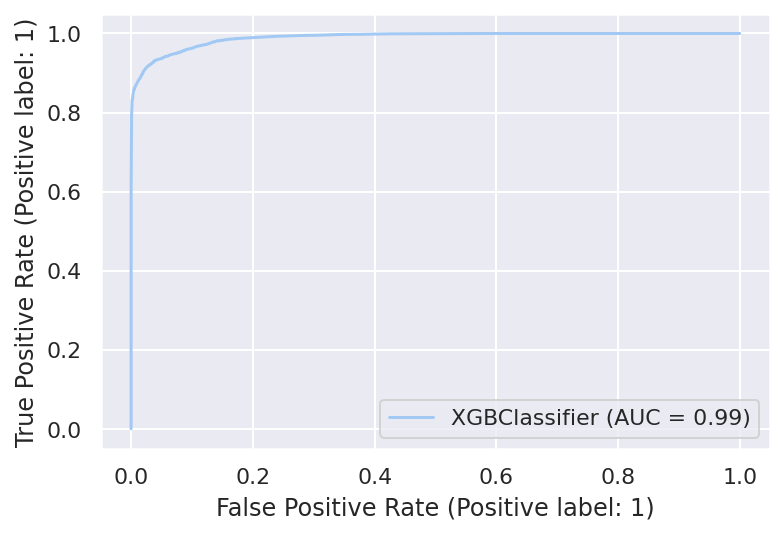

In [157]:
params = {'n_estimators': 10, 'max_depth': 16}

model1 = xgb.XGBClassifier(**params)
model1.fit(X_train_scaled, y_train)
y_pred = model1.predict(X_val_scaled)

y_pred_proba = model1.predict_proba(X_val_scaled)[:, 1]
plot_roc_curve(model1, X_val_scaled, y_val)

auc_score = roc_auc_score(y_val, y_pred_proba)
print(classification_report(y_val, y_pred, digits=5))
print('최종 검증 정확도: ', accuracy_score(y_val, y_pred))
print('최종 auc점수 : ', auc_score)

Report 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95     14573
           1       0.95      0.92      0.94     11403

    accuracy                           0.95     25976
   macro avg       0.95      0.94      0.95     25976
weighted avg       0.95      0.95      0.95     25976

테스트 정확도 0.9466430551278103
f1 스코어 0.9382683057188669
auc점수 :  0.9891528808094029


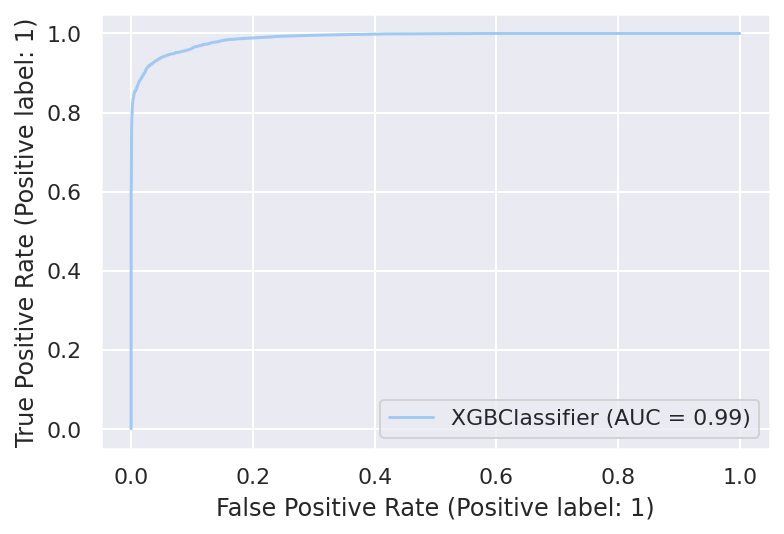

In [158]:
# 테스트 데이터 성능확인
y_pred = model1.predict(X_test_scaled)

y_pred_proba = model1.predict_proba(X_test_scaled)[:, 1]
plot_roc_curve(model1, X_test_scaled, y_test)
auc_score = roc_auc_score(y_test, y_pred_proba)

print('Report \n',classification_report(y_test, y_pred))
print('테스트 정확도', model1.score(X_test_scaled, y_test))
print('f1 스코어',f1_score(y_test, y_pred))
print('auc점수 : ', auc_score)

***=> 정확도 : 0.946, auc : 0.989***

In [159]:
permuter_xgb = PermutationImportance(model1, scoring = 'roc_auc', n_iter = 5, random_state = 2)
permuter_xgb.fit(X_val_scaled, y_val)

eli5.show_weights(permuter_xgb, top = None, feature_names = X_val.columns.tolist())

Weight,Feature
0.1439 ± 0.0038,Type_of_Travel
0.1193 ± 0.0006,Inflight_wifi_service
0.0412 ± 0.0021,Online_boarding
0.0374 ± 0.0011,Customer_Type
0.0252 ± 0.0014,Baggage_handling
0.0206 ± 0.0012,Seat_comfort
0.0156 ± 0.0004,Class
0.0116 ± 0.0012,Inflight_entertainment


In [163]:
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_val_scaled)

In [169]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[0, :], X_val.iloc[0, :]) ##하나의 데이터

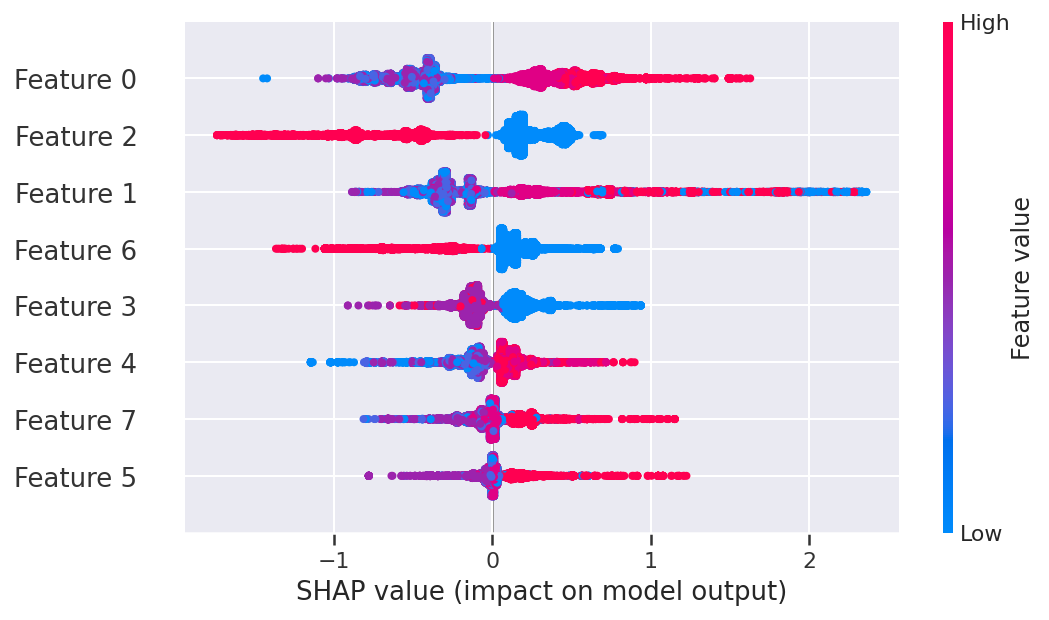

In [166]:
shap.summary_plot(shap_values, X_val_scaled)

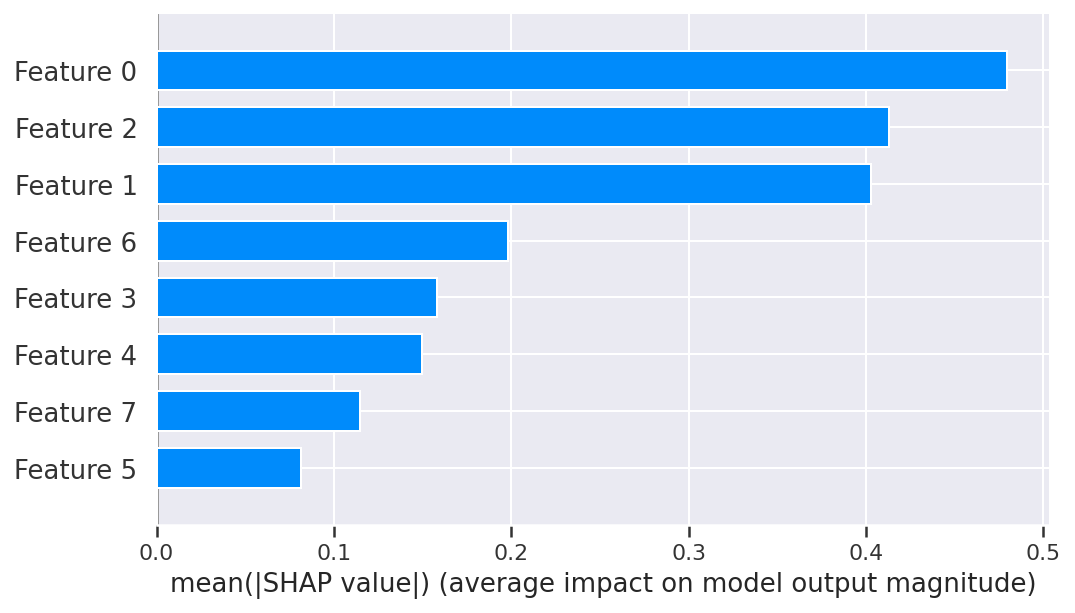

In [167]:
shap.summary_plot(shap_values, X_val_scaled, plot_type = 'bar')